In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import matplotlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
# 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
# 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67

# Скачиваем данные

In [131]:
def read_file(file):
    df = pd.read_csv(file)
    df = df.drop_duplicates()
    #print(df.shape)
    
    return df

In [132]:
df = pd.DataFrame()
for i in range(1,68):
    data = read_file(f'auto{i}.csv')
    df = pd.concat([df, data], ignore_index=True)
    
df = df.drop_duplicates()
df.shape

(22702, 58)

# 1.Обработка данных

In [133]:
def get_cols(df) -> list:
    '''
    функция возвращает список категориальных и числовых переменных
    '''
    categorical_feature_mask = df.dtypes == object
    number_feature_mask = df.dtypes != object
    numbers_cols = df.columns[number_feature_mask].tolist()
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    return [numbers_cols, categorical_cols]

In [134]:
# смотрим на пропущенные значения в % и отберем все стобцы, где пропущены данные < 0.2% от общего количества 
cols = df.apply(lambda x: f'{(x.isna().sum()/df.shape[0]).round(2)} %').sort_values()[:-4].index.to_list()
df = df[cols]
df.sample(1)

,mark,Коробка,Привод,Количество мест,Количество дверей,Страна марки,Тип двигателя,Объем,Мощность,Цвет,...,"Максимальная скорость, км/ч",Размер колёс,Разгон,Количество передач,"Разгон до 100 км/ч, с","Полная масса, кг",Степень сжатия,Расход,Система питания двигателя,"Расход топлива, л город/трасса/смешанный"
13797,Volvo,автомат,передний,5,5,Швеция,бензин,1.5 л,152 л.с.,серый,...,210.0,NaN,8.5 с,6.0,8.5,NaN,10.5,5.6 л,непосредственный впрыск (прямой),NaN


In [135]:
numbers_cols, categorical_cols = get_cols(df)

In [136]:
#смотрим на пропущенные числовые значения
df[numbers_cols].apply(lambda x: x.isna().sum())

Количество дверей                 0
Пробег                            0
год выпуска                       0
Объем двигателя, см³            247
Ширина                          191
Длина                           191
Колёсная база                   191
Количество цилиндров            191
Высота                          191
Число клапанов на цилиндр       346
Объём топливного бака, л        491
Ширина задней колеи             680
Ширина передней колеи           680
Снаряженная масса, кг          1237
Максимальная скорость, км/ч    1310
Количество передач             1598
Разгон до 100 км/ч, с          1735
Полная масса, кг               2339
Степень сжатия                 2737
dtype: int64

In [137]:
# меняем пропущенные числовые признаки на их среднее по столбцу
for col in df[numbers_cols].columns.to_list():
    df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype('float')

### работаем с исходными столбцами, иницализируем составные переменные, удаляем дубликаты

In [138]:
df['car_type'] = [i.split(' ')[0] for i in df['car_type']]

df['Рестайлинг'] = [1.0 if 'Рестайлинг' in i else 0.0 for i in df['pokolenie']]

df['Cерия начала выпуска'] = [float(i.strip().split(' ')[-3:][0]) for i in df['pokolenie']]
df['Cерия конца выпуска'] = [float(i.strip().split(' ')[-3:][2])
                                 if 'н.в.' not in i.strip().split(' ')[-3:][2]
                                 else 2020
                                 for i in df['pokolenie']]

df['Цена'] = [i.split('₽')[0].replace('\xa0', '') for i in df['Цена']]
df['Цена'] = df['Цена'].astype('float')

df['Диаметр цилиндра и ход поршня, мм'] =  [float(i.split(' × ')[0])
                    if str(i).split('/')[0].strip() not in ['nan', '-'] 
                    else 0
                    for i in df['Диаметр цилиндра и ход поршня, мм']]

df['Клиренс'] = [float(str(i).split(',')[0])
                     if not math.isnan(float(str(i).split(',')[0]))
                     else 0
                     for i in df['Клиренс']]

df['Количество мест'] = [float(float(str(i).split(',')[0]))
                     if not math.isnan(float(str(i).split(',')[0]))
                     else 0
                     for i in df['Количество мест']]


df['Максимальная мощность, л.с./кВт при об/мин'] = [float(str(i).split('/')[0].strip())
                                                        if str(i).split('/')[0].strip() != 'nan'
                                                        else 0
                                                        for i in df['Максимальная мощность, л.с./кВт при об/мин']]

df['Максимальный крутящий момент, Н*м при об/мин'] = [float(i.split(' ')[0])
                                                        if str(i).split('/')[0].strip() != 'nan'
                                                        else 0
                                                        for i in df['Максимальный крутящий момент, Н*м при об/мин']]


df['Объем'] = [float(i.split(' ')[0])
                    if str(i).split('/')[0].strip() != 'nan'
                    else 0
                    for i in df['Объем']]

df['Объем багажника max'] = [float(str(i).split('/')[0])
                                if str(i).split('/')[0] not in ['nan', '-'] 
                                else 0
                                for i in df['Объем багажника мин/макс, л']]

df['Объем багажника min'] = [float(str(i).split('/')[1])
                                if len(str(i).split('/')) != 1
                                else 0
                                for i in df['Объем багажника мин/макс, л']]

df['Расход'] = [float(str(i).split(' ')[0])
                    if len(str(i).split(' ')) != 1
                    else 0
                    for i in df['Расход']]

df['Расход л город'] = [float(str(i).split('/')[0])
                            if len(str(i).split('/')) != 1
                            else 0
                            for i in df['Расход топлива, л город/трасса/смешанный']]

df['Расход л трасса'] = [float(str(i).split('/')[1])
                            if len(str(i).split('/')) != 1
                            else 0
                            for i in df['Расход топлива, л город/трасса/смешанный']]

df['Расход л среднее'] = [float(str(i).split('/')[2])
                            if len(str(i).split('/')) != 1
                            else 0
                            for i in df['Расход топлива, л город/трасса/смешанный']]

df.drop(['Расход топлива, л город/трасса/смешанный'], axis = 1, inplace = True)
df.drop(['Объем багажника мин/макс, л'], axis = 1, inplace = True)
df.drop(['Разгон'], axis = 1, inplace = True)
df.drop(['Мощность'], axis = 1, inplace = True)
df.drop(['Коробка передач'], axis = 1, inplace = True)

In [139]:
# переменовываем названия колонок
df.columns  = [col.replace(' см','').replace(' л','').replace(' мм','').replace(' при об/мин','')\
     .replace(' км/ч','').replace(',.с./кВт','')\
     .replace(' ','_').replace('/', '').replace('³','').replace('*','').replace(',','')
     for col in df.columns.to_list()]

In [140]:
df.columns

Index(['mark', 'Коробка', 'Привод', 'Количество_мест', 'Количество_дверей',
       'Страна_марки', 'Тип_двигателя', 'Объем', 'Цвет', 'Пробег', 'Цена',
       'год_выпуска', 'car_type', 'pokolenie', 'model', 'Топливо',
       'Тип_привода', 'Тип_наддува', 'Расположение_цилиндров',
       'Передние_тормоза', 'Объем_двигателя', 'Ширина',
       'Тип_передней_подвески', 'Диаметр_цилиндра_и_ход_поршня',
       'Максимальная_мощность', 'Длина', 'Класс_автомобиля', 'Колёсная_база',
       'Количество_цилиндров', 'Высота', 'Марка_топлива',
       'Максимальный_крутящий_момент_Нм', 'Число_клапанов_на_цилиндр',
       'Объём_топливного_бака', 'Ширина_задней_колеи', 'Тип_задней_подвески',
       'Задние_тормоза', 'Ширина_передней_колеи', 'Снаряженная_масса_кг',
       'Клиренс', 'Расположение_двигателя', 'Максимальная_скорость',
       'Размер_колёс', 'Количество_передач', 'Разгон_до_100_с',
       'Полная_масса_кг', 'Степень_сжатия', 'Расход',
       'Система_питания_двигателя', 'Рестайлинг', 'C

In [141]:
df.sample(1)

,mark,Коробка,Привод,Количество_мест,Количество_дверей,Страна_марки,Тип_двигателя,Объем,Цвет,Пробег,...,Расход,Система_питания_двигателя,Рестайлинг,Cерия_начала_выпуска,Cерия_конца_выпуска,Объем_багажника_max,Объем_багажника_min,Расход_город,Расход_трасса,Расход_среднее
19383,Suzuki,автомат,полный,5.0,5.0,Япония,бензин,2.7,бежевый,187000.0,...,11.5,распределенный впрыск (многоточечный),1.0,2000.0,2006.0,187.0,2067.0,15.6,9.9,11.5


In [142]:
df.to_csv('autoru_v01.csv')

# 2.Визуализация данных

In [143]:
colors = {
    'cur_price':'#bb5ee6',
    'fuel':'mako_r', 
    'transmission_type':'binary_r',
    'retailer':'Blues', 
    'town':'PuBuGn_r', 
    'brand':'OrRd',
    'car_type':'plasma_r'
}

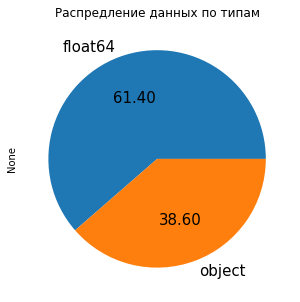

In [144]:
pd.Series([df[i].dtype for i in df.columns])\
                                .value_counts()\
                                .plot(
                                    kind = 'pie', autopct="%.2f",
                                    title = 'Распредление данных по типам',
                                    fontsize=15,
                                    figsize=(5, 5))

In [145]:
df['mark'].unique()

array(['Mercedes-Benz ', 'Mitsubishi ', 'Audi ', 'Volkswagen ', 'Jaguar ',
       'Nissan ', 'Infiniti ', 'Skoda ', 'Haval ', 'Renault ',
       'LADA (ВАЗ) ', 'Jeep ', 'Volvo ', 'BMW ', 'Toyota ', 'Land Rover ',
       'MINI ', 'Hyundai ', 'УАЗ ', 'Suzuki ', 'Citroen ', 'Peugeot ',
       'Changan ', 'Chevrolet ', 'Bentley ', 'Cadillac ', 'Lamborghini ',
       'Kia ', 'Rolls-Royce ', 'Lexus ', 'Subaru ', 'Dodge ', 'Porsche ',
       'Genesis ', 'Honda ', 'Lincoln ', 'Mazda ', 'Ford ', 'Geely ',
       'Opel ', 'Smart ', 'AC ', 'Chery ', 'Tesla ', 'ТагАЗ ',
       'Great Wall ', 'SsangYong ', 'ГАЗ ', 'SEAT ', 'Fiat ', 'Datsun ',
       'Acura ', 'Daewoo ', 'Ravon ', 'Isuzu ', 'Lifan ', 'Chrysler ',
       'Ferrari ', 'Luxgen ', 'Vortex ', 'Москвич ', 'Daihatsu ', 'Saab ',
       'DongFeng ', 'ЗАЗ ', 'Alfa Romeo ', 'Iran Khodro ', 'GMC ',
       'Maserati ', 'Maybach ', 'Hummer ', 'DW Hower ', 'FAW ', 'Hawtai ',
       'ЛуАЗ ', 'Rover ', 'McLaren ', 'ZX ', 'Aston Martin ', 'AMC ',
    

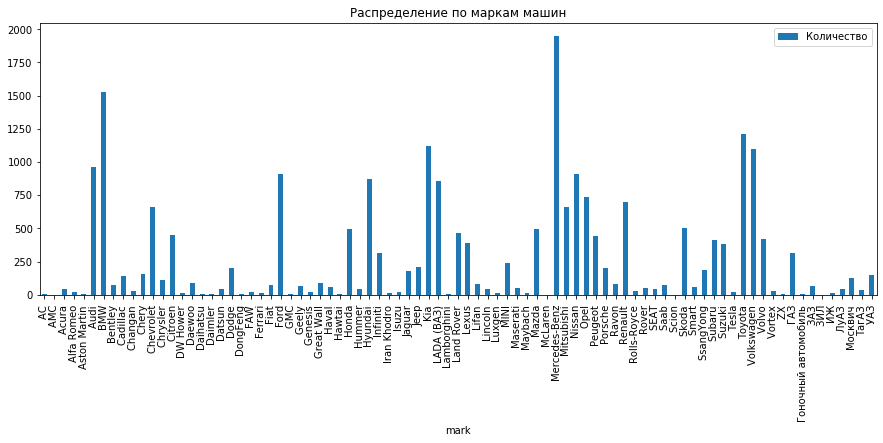

In [146]:
plt.figure(figsize=(16,8))
df.groupby(['mark']).size().plot(kind = 'bar',figsize=(15,5), title = 'Распределение по маркам машин', label = 'Количество')
plt.legend()

In [147]:
def millions(x, pos):
    return '{:,.1f}M'.format(x*1e-6)
fmtr = matplotlib.ticker.FuncFormatter(millions)

Медианная стоимость машин составила 680000 рублей


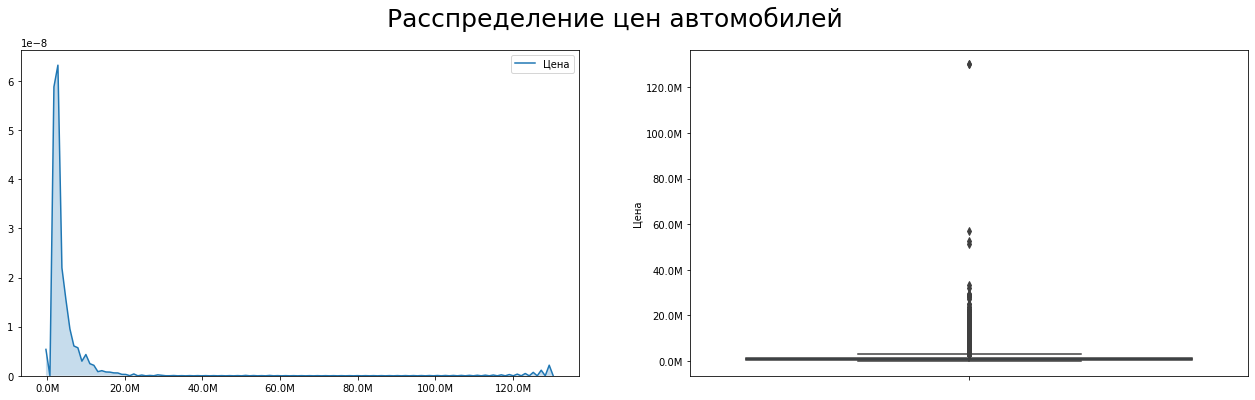

In [148]:
print(f'Медианная стоимость машин составила {int(df.Цена.median())} рублей')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))

plt.subplot(1,2,1)
ax = sns.kdeplot(df.Цена, shade=True)
_ = ax.xaxis.set_major_formatter(fmtr)

plt.subplot(1,2,2)
ax = sns.boxplot(y=df.Цена)
_ = ax.yaxis.set_major_formatter(fmtr)

fig.suptitle("Расспределение цен автомобилей",fontsize=25)
plt.show()

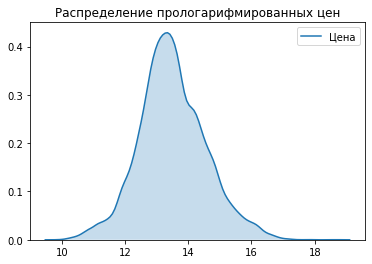

In [149]:
sns.kdeplot(np.log(df.Цена), shade=True)
plt.title('Распределение прологарифмированных цен')
plt.show()

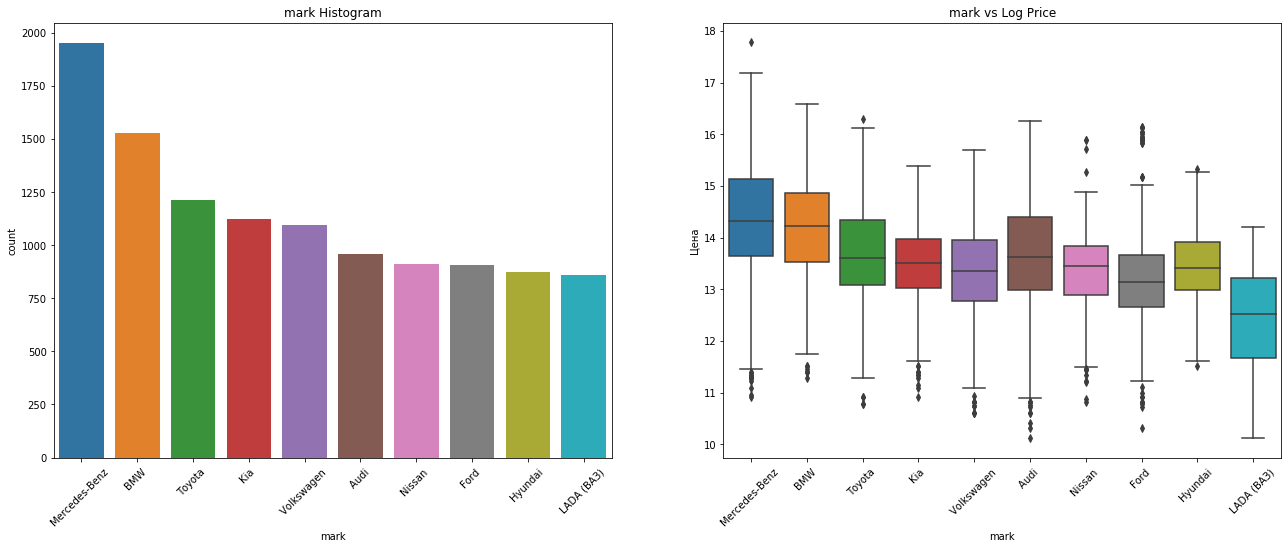

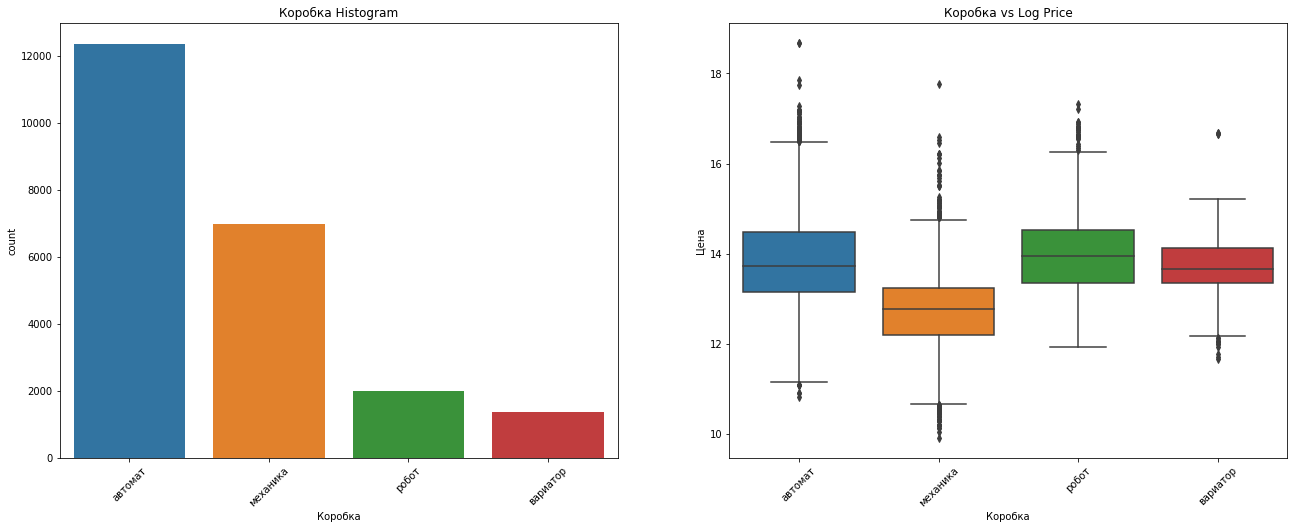

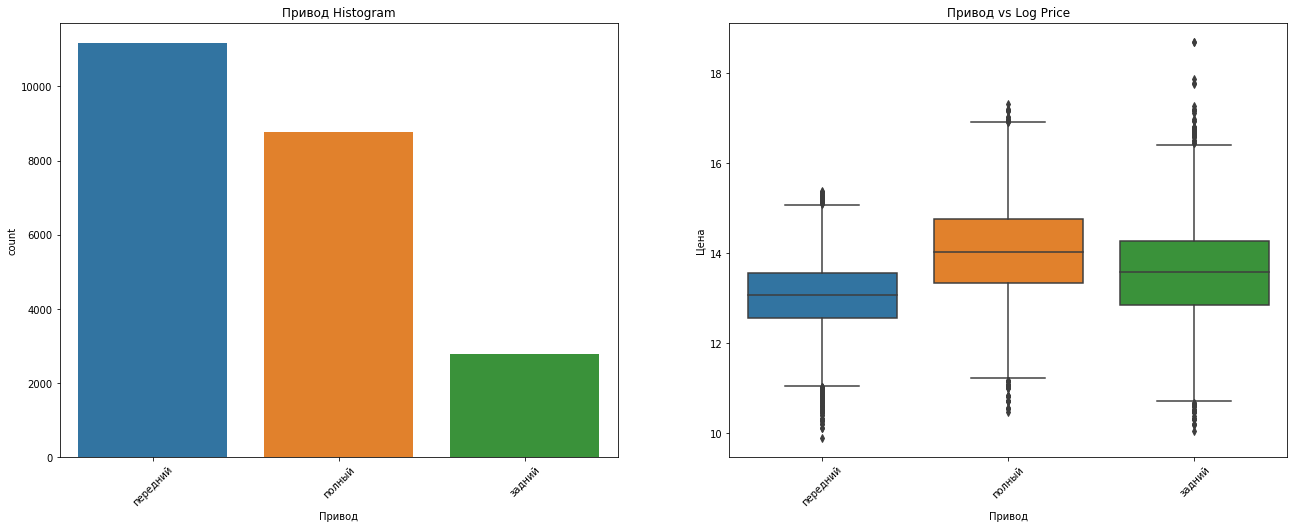

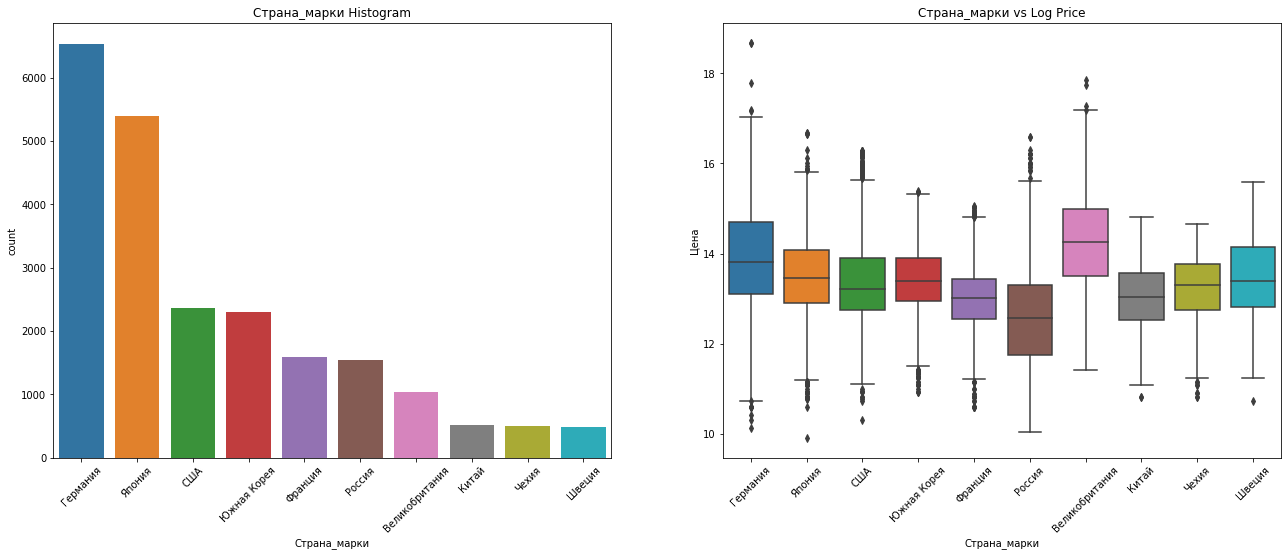

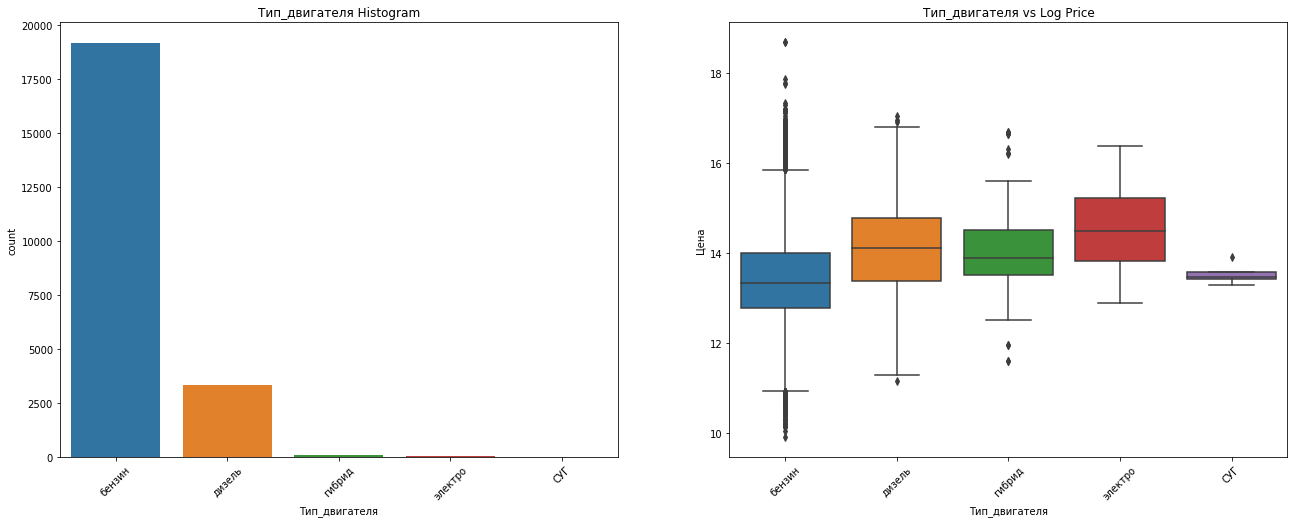

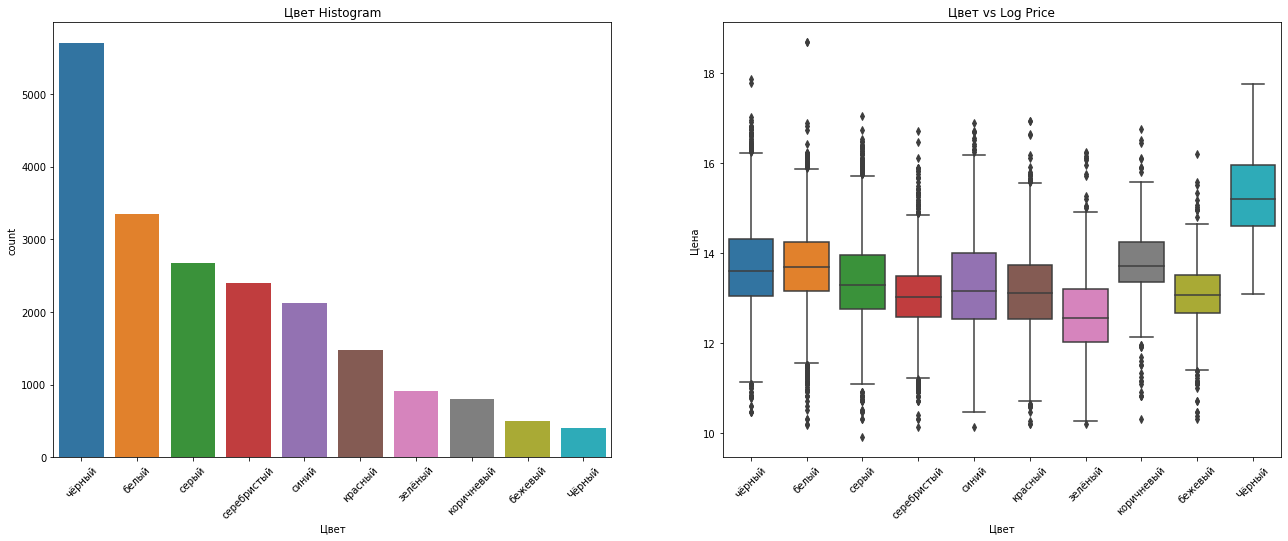

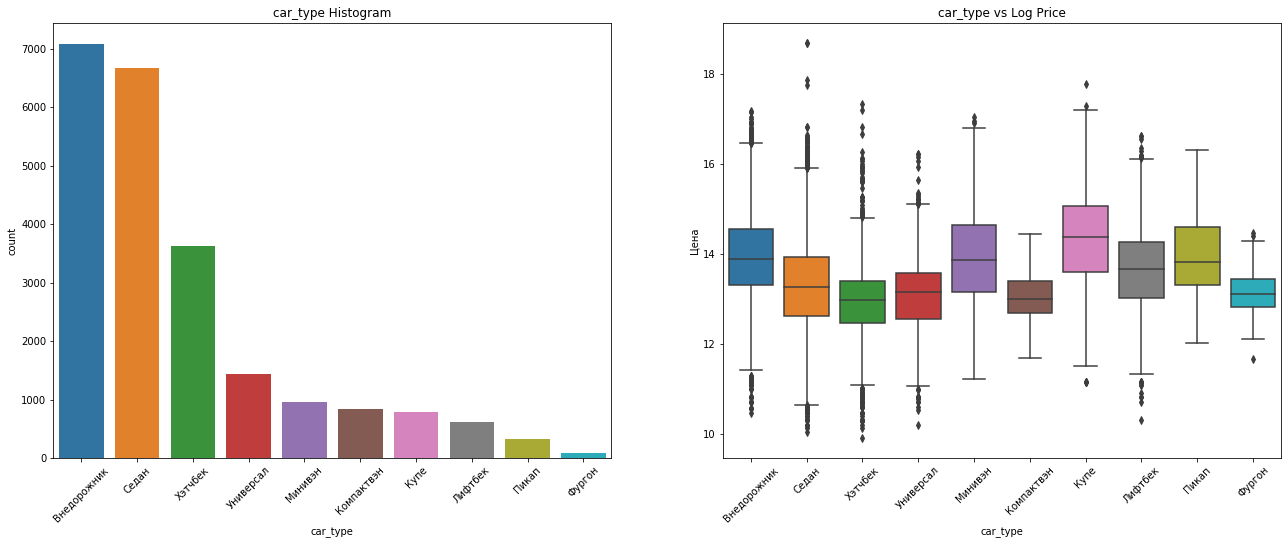

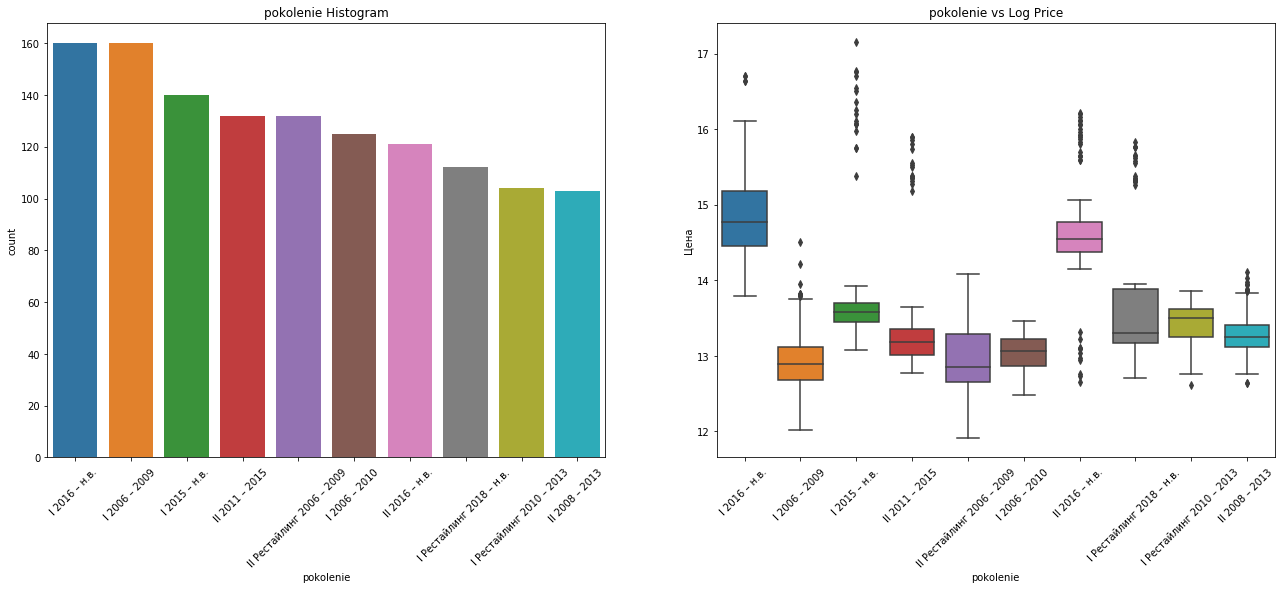

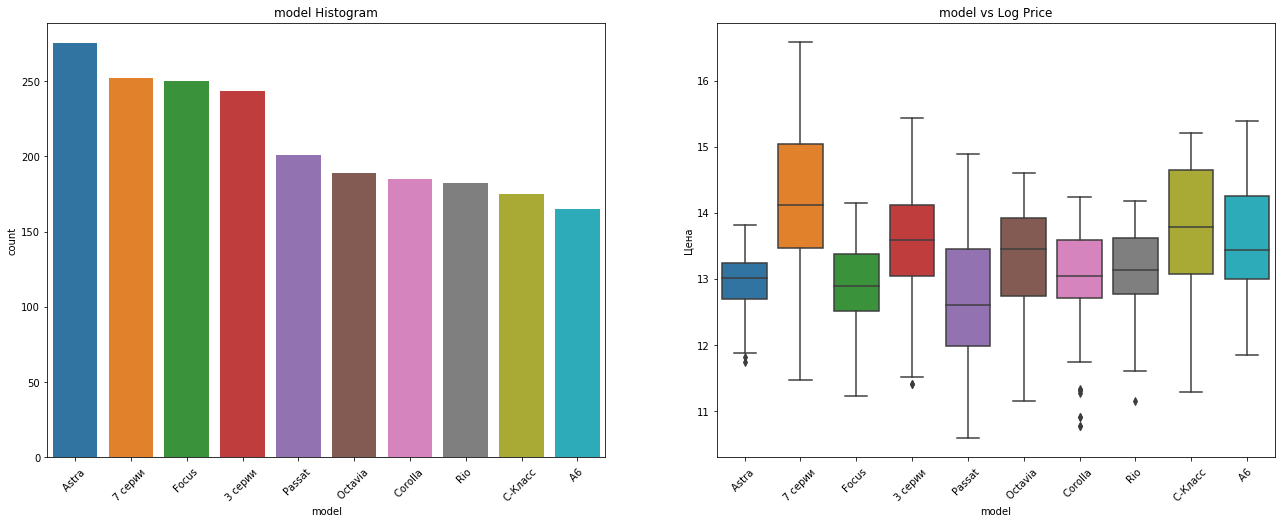

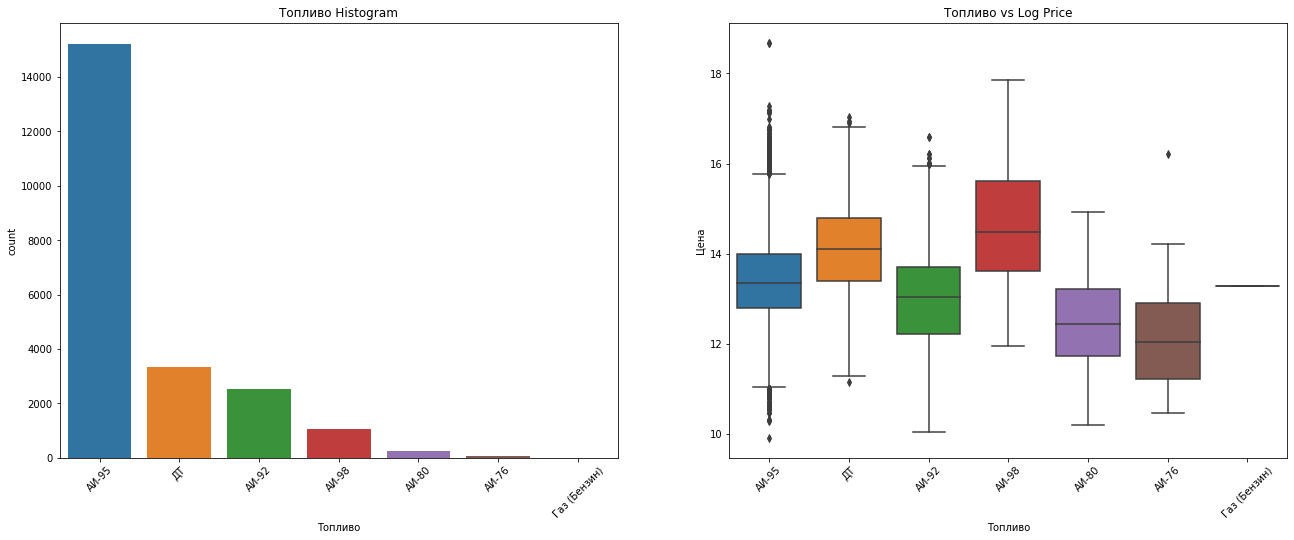

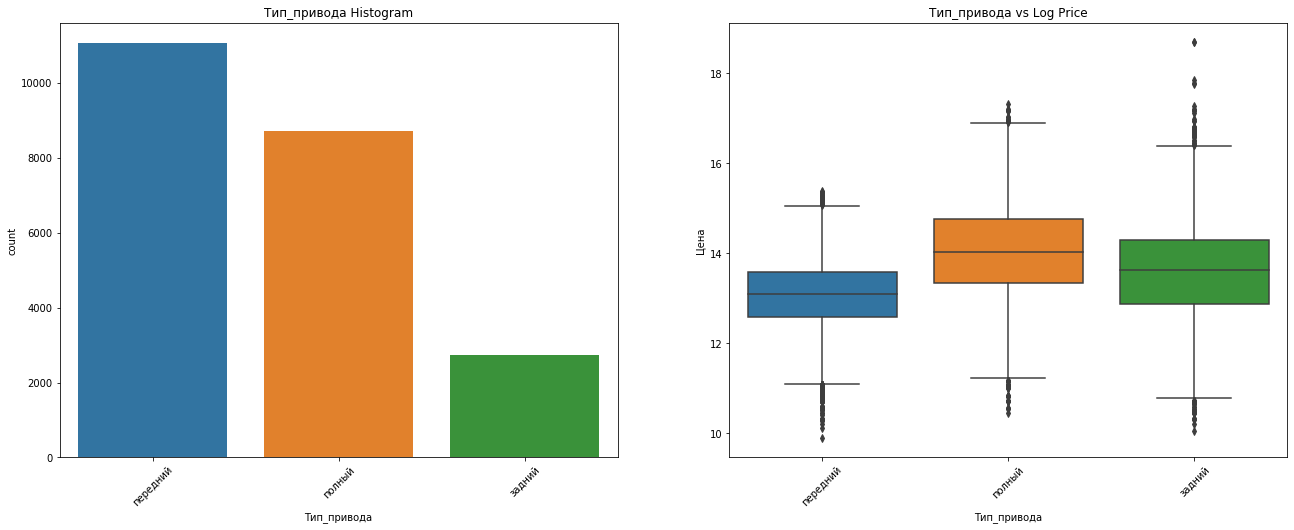

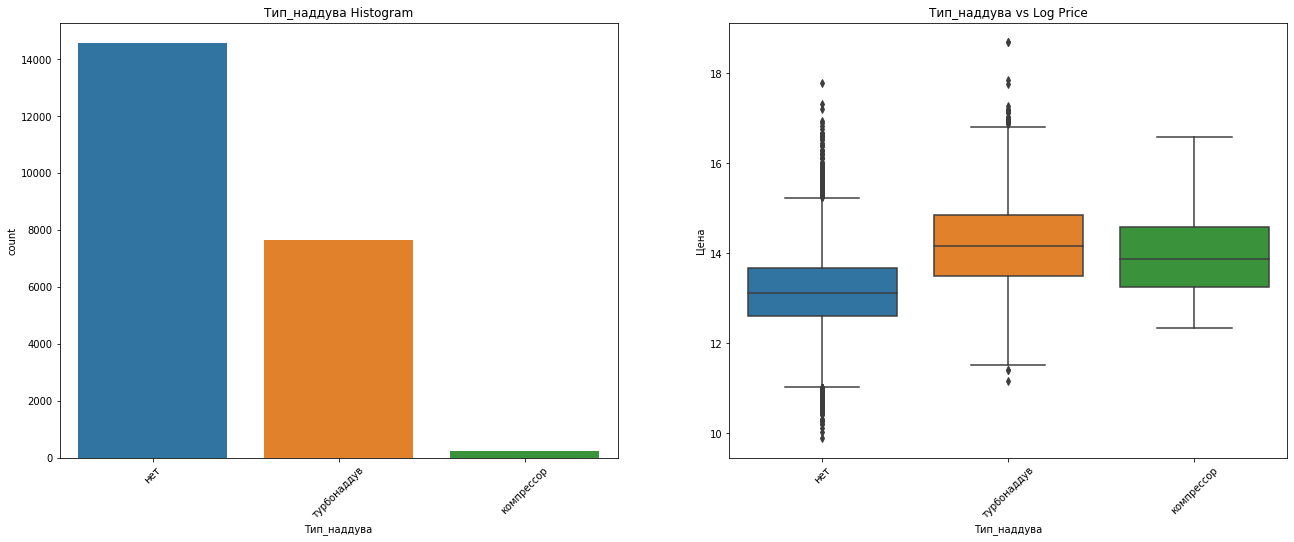

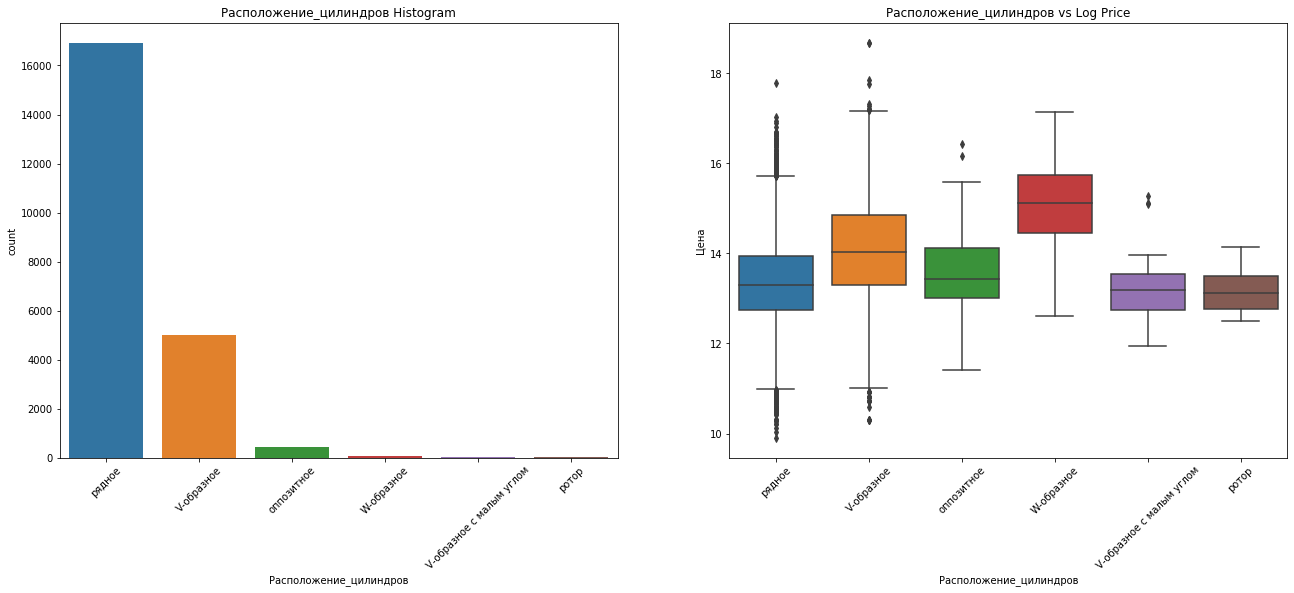

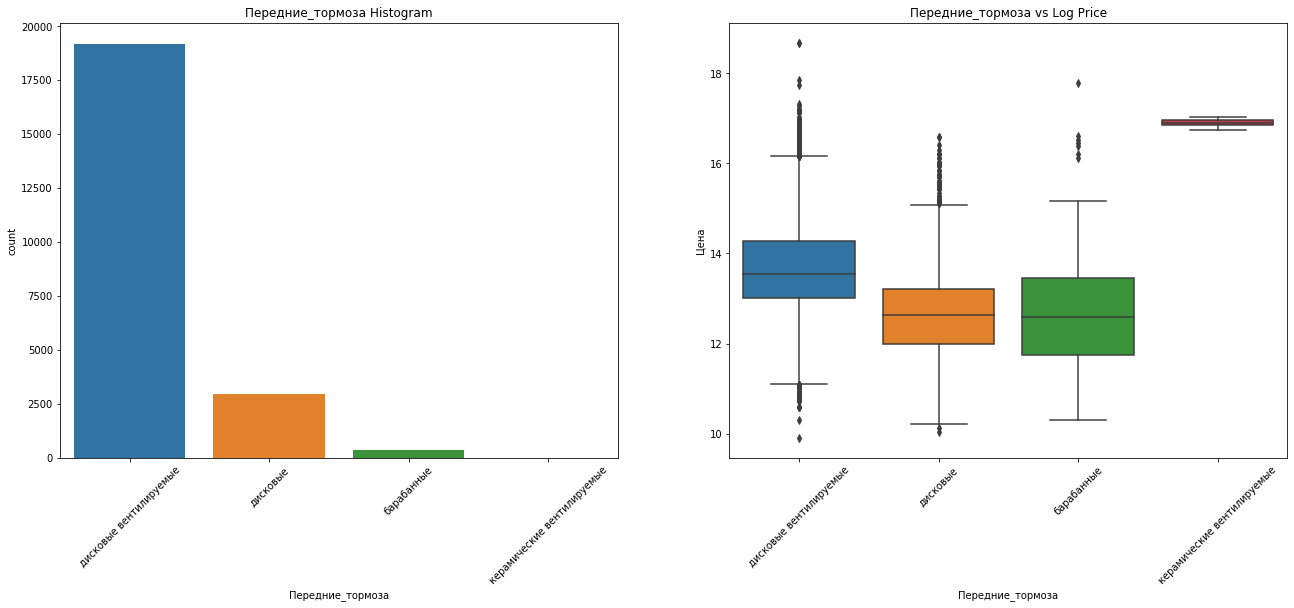

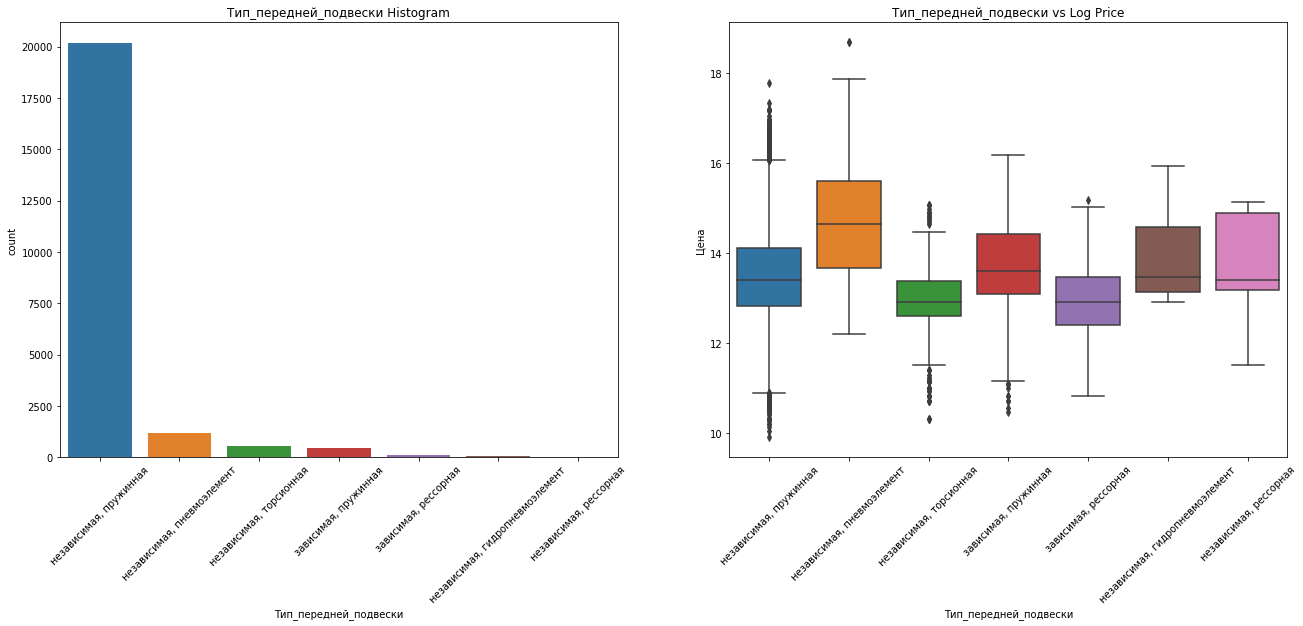

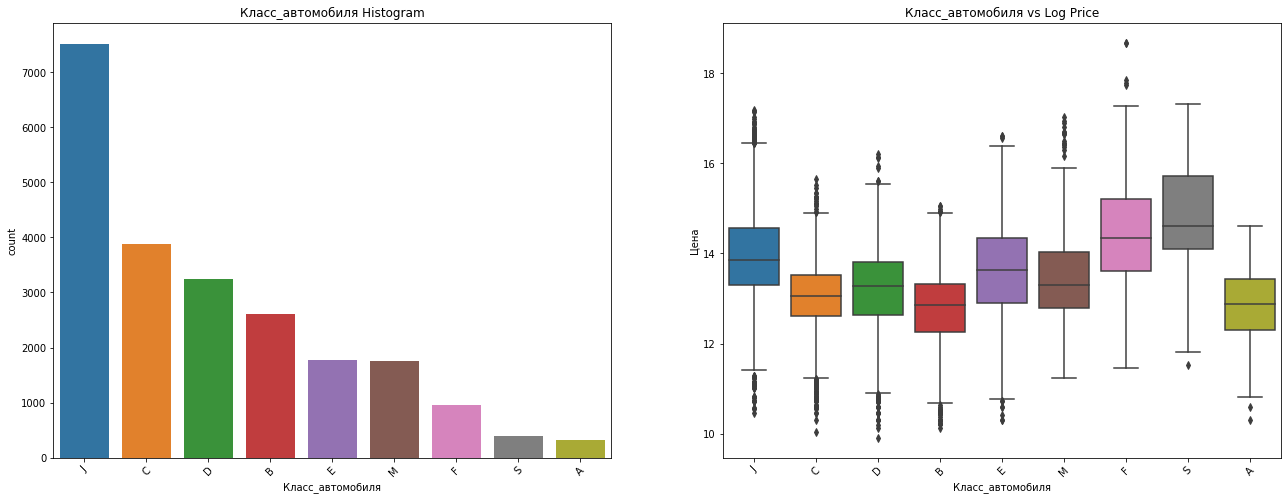

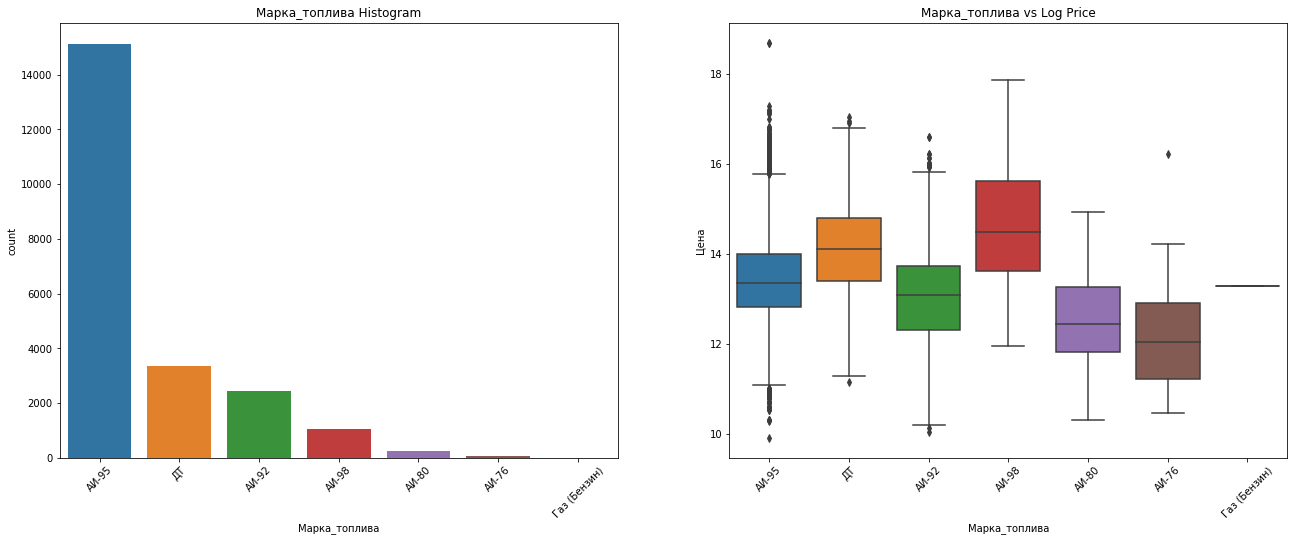

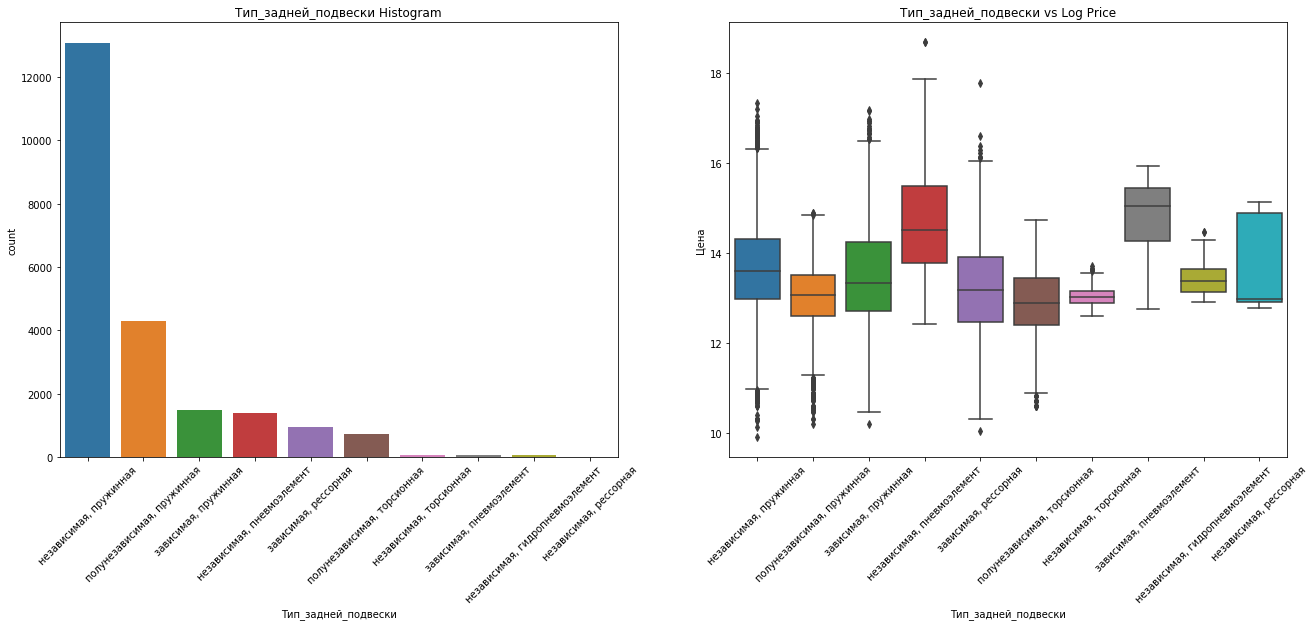

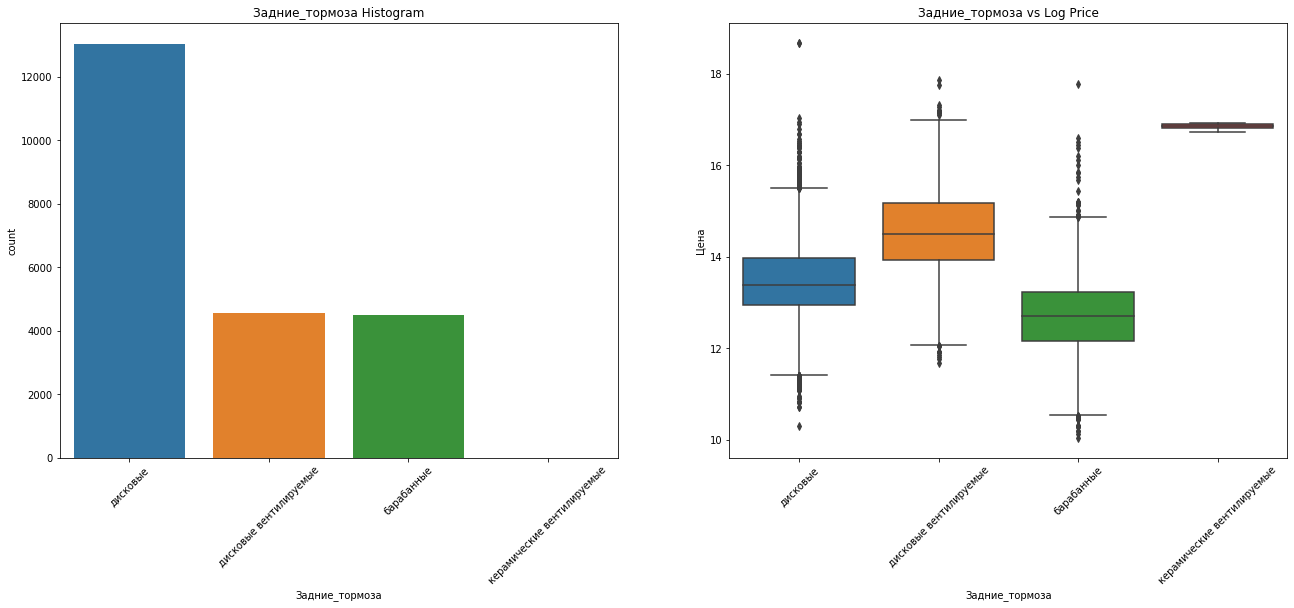

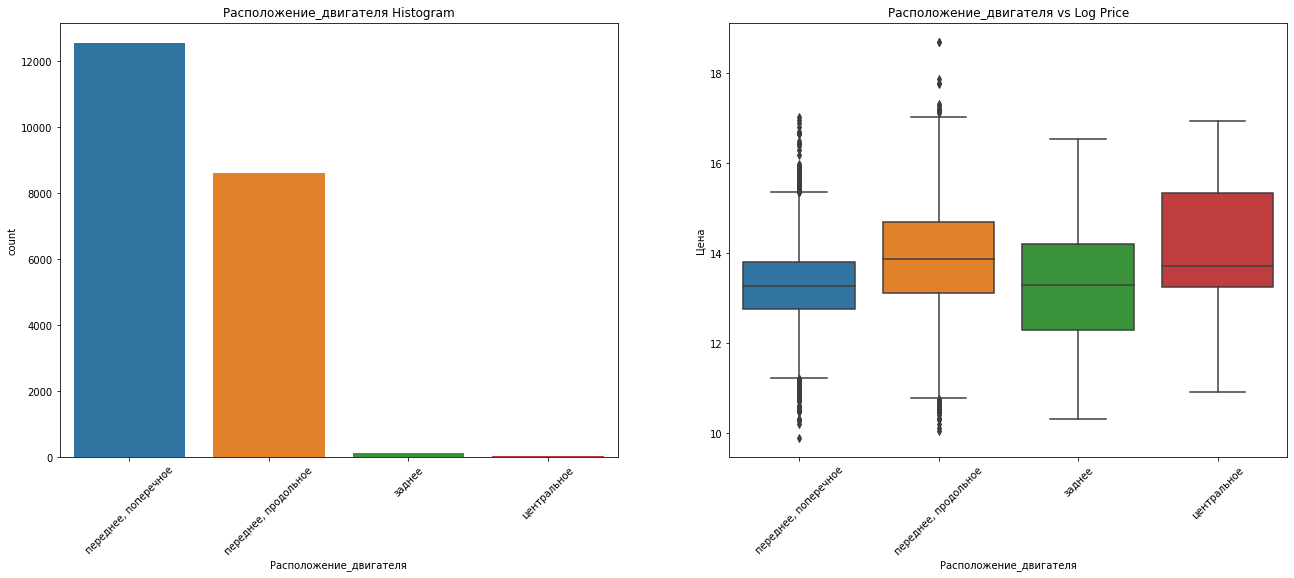

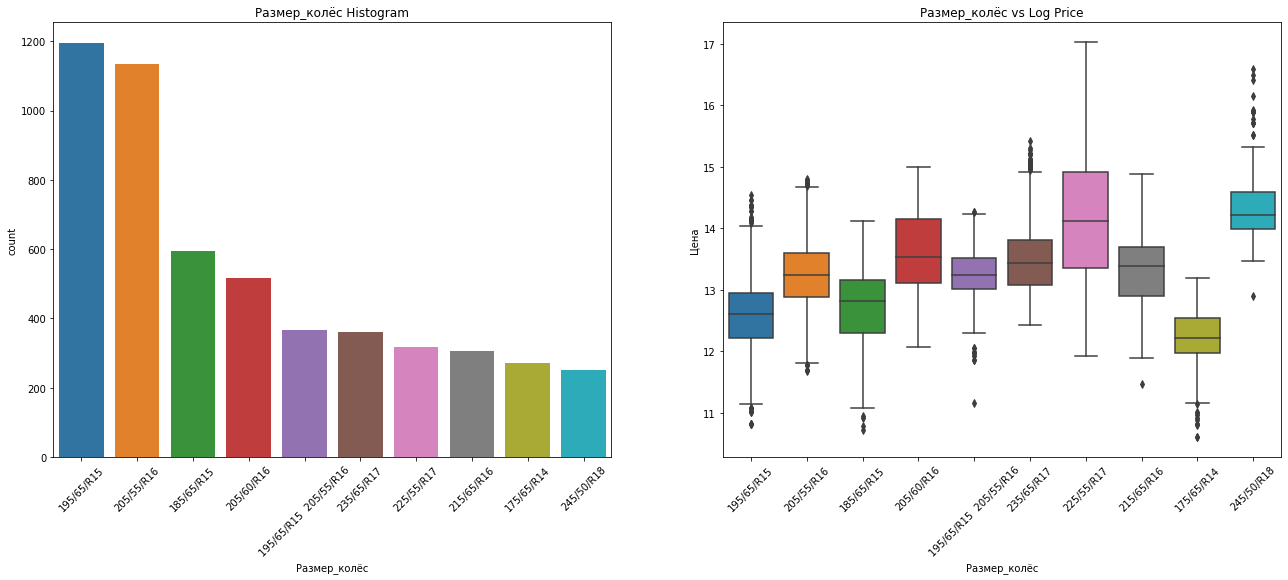

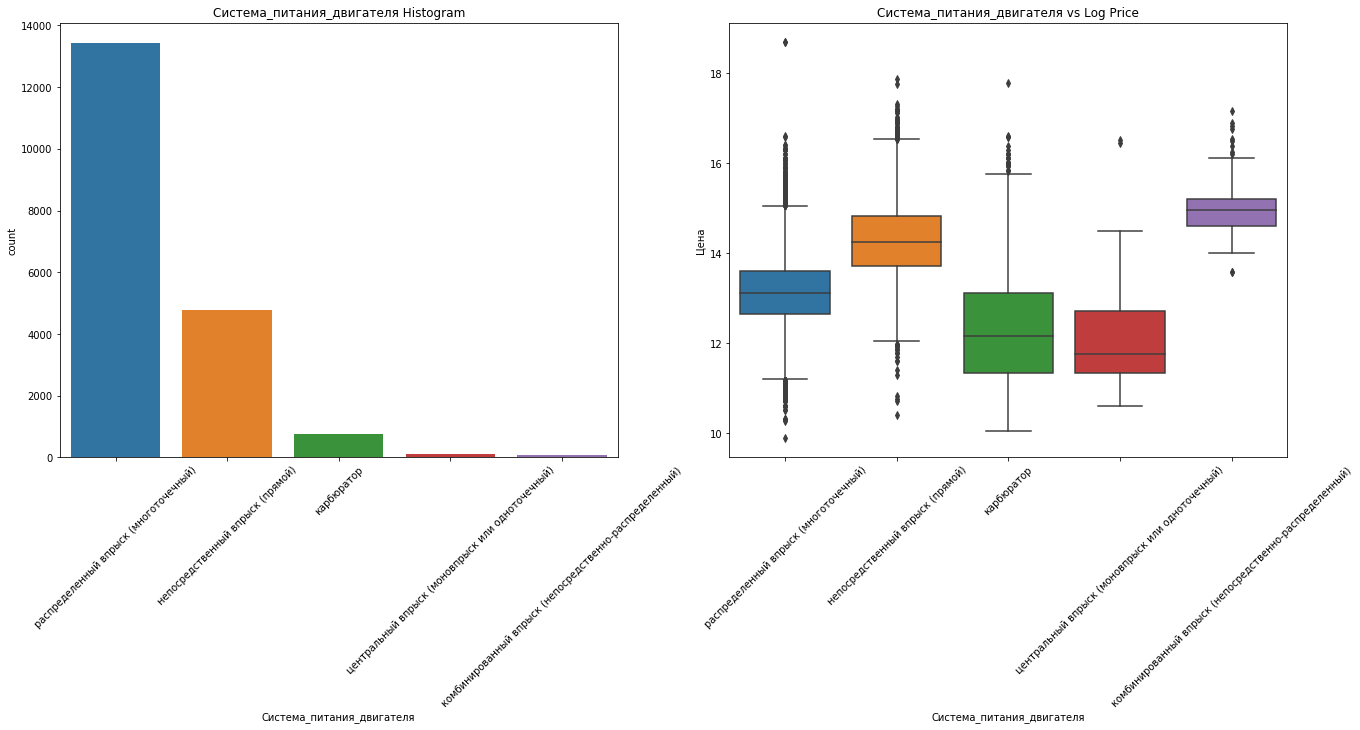

In [150]:
numbers_cols, categorical_cols = get_cols(df)

for column in categorical_cols:
    
    columne_most_freq = df[column].value_counts()[:10].sort_values(ascending=False).index
    
    if '' in columne_most_freq:
        columne_most_freq = columne_most_freq.drop('')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8))    
    
    plt.subplot(1,2,1)
    plt.title(f'{column} Histogram')
    sns.countplot(
            df[df[column].isin(columne_most_freq)][column],
            order=columne_most_freq
    )
    
    plt.xticks(rotation=45)

    plt.subplot(1,2,2)
    plt.title(f'{column} vs Log Price')
    ax = sns.boxplot(
            x=df[df[column].isin(columne_most_freq)][column], 
            y=np.log(df[df[column].isin(columne_most_freq)].Цена), 
            order=columne_most_freq
    )
    plt.xticks(rotation=45)

    plt.show()

In [151]:
len(numbers_cols)

35

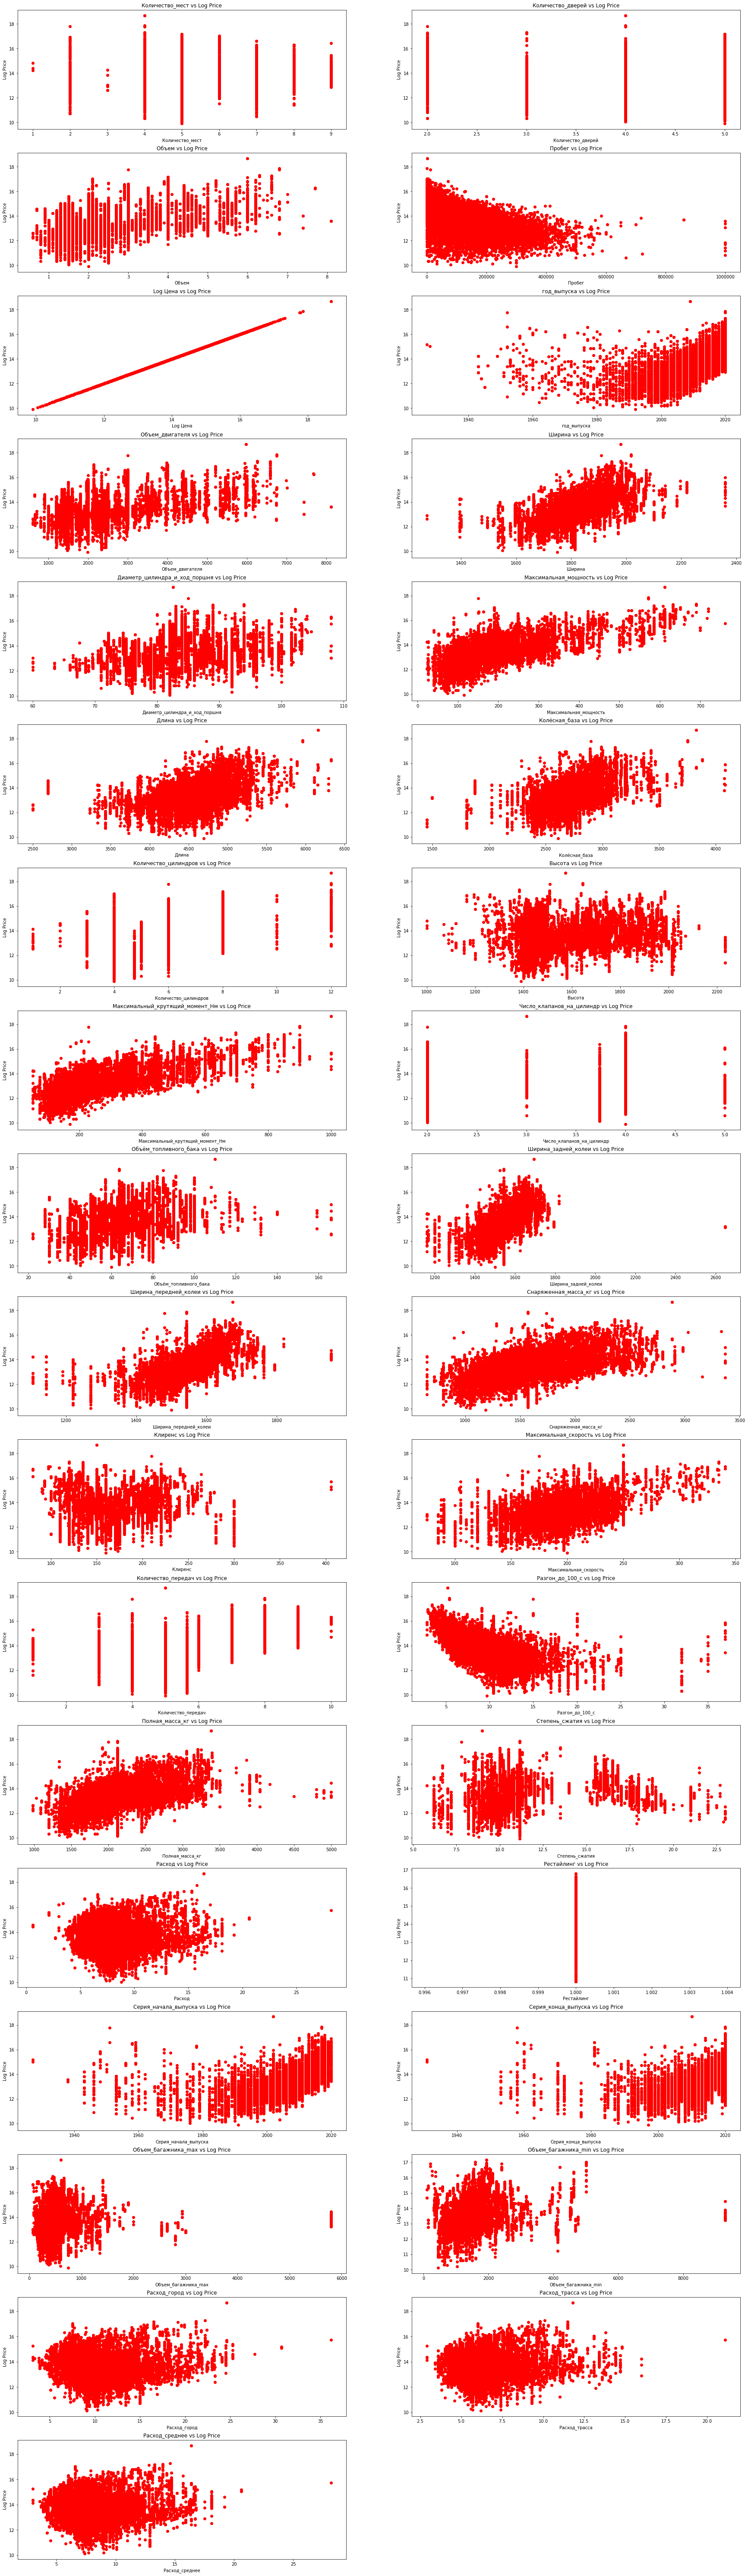

In [152]:
def scatter(column,fig):
    plt.subplot(33,2,fig)
    ax = plt.scatter(
        x=[price if 'Цена' not in column else np.log(price) for price in df[df[column] > 0][column]],
        y=np.log(df[df[column] > 0].Цена),
        color = 'red'
    )
    plt.title(f'{column} vs Log Price', fontsize=40)
    plt.title(f'{column} vs Log Price' if 'Цена' not in column else f'Log {column} vs Log Price')
    plt.ylabel('Log Price')
    plt.xlabel(column if 'Цена' not in column else f'Log {column}')

plt.figure(figsize=(30,200))

for i, column in enumerate(numbers_cols):
    scatter(column, i + 1)


# Описательная статистика

In [153]:
df.describe()

,Количество_мест,Количество_дверей,Объем,Пробег,Цена,год_выпуска,Объем_двигателя,Ширина,Диаметр_цилиндра_и_ход_поршня,Максимальная_мощность,...,Степень_сжатия,Расход,Рестайлинг,Cерия_начала_выпуска,Cерия_конца_выпуска,Объем_багажника_max,Объем_багажника_min,Расход_город,Расход_трасса,Расход_среднее
count,22702.00000,22702.000000,22702.000000,22702.000000,2.270200e+04,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000,...,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000,22702.000000
mean,5.01251,4.418774,2.334922,136649.516210,1.353936e+06,2009.204563,2337.199911,1813.402914,73.521181,179.413488,...,11.149437,7.154378,0.339794,2006.610078,2011.682451,472.146991,853.949520,8.730698,5.339745,6.605114
std,0.76348,0.810206,1.049301,101154.431413,2.493866e+06,9.116164,1037.923141,98.746721,27.948965,103.903355,...,2.438177,3.640578,0.473650,10.340075,8.284589,321.706597,937.394434,5.345248,3.120095,3.929169
min,1.00000,0.000000,0.000000,0.000000,2.000000e+04,1927.000000,599.000000,1275.000000,0.000000,0.000000,...,5.800000,0.000000,0.000000,1927.000000,1931.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.00000,4.000000,1.600000,62322.000000,3.740750e+05,2006.000000,1598.000000,1755.000000,77.000000,114.000000,...,10.000000,6.100000,0.000000,2003.000000,2008.000000,352.000000,0.000000,6.900000,4.700000,5.600000
50%,5.00000,5.000000,2.000000,125000.000000,6.800000e+05,2011.000000,1997.000000,1810.000000,82.000000,150.000000,...,10.500000,7.400000,0.000000,2008.000000,2013.000000,456.000000,815.000000,9.400000,5.800000,7.200000
75%,5.00000,5.000000,2.700000,191786.000000,1.420000e+06,2015.000000,2693.000000,1875.000000,86.200000,218.000000,...,11.149437,9.100000,1.000000,2013.000000,2018.000000,530.000000,1547.000000,11.700000,7.100000,8.800000
max,9.00000,5.000000,8.100000,1000000.000000,1.300000e+08,2020.000000,8128.000000,2360.000000,108.000000,762.000000,...,23.000000,28.200000,1.000000,2020.000000,2020.000000,5800.000000,9300.000000,36.200000,21.100000,28.200000


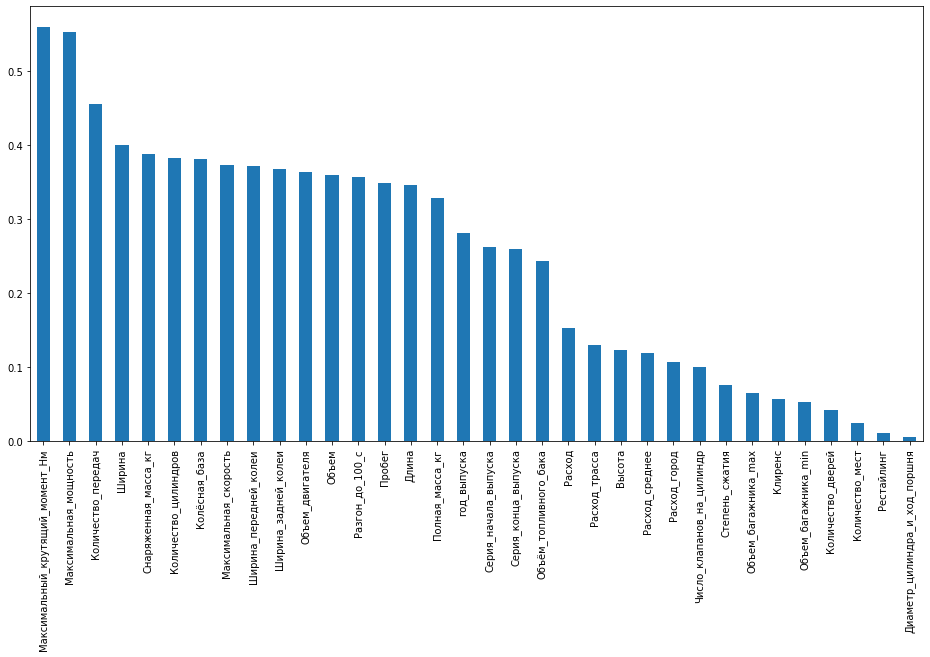

In [154]:
# корреляция признаков
plt.figure(figsize=(16,8))
abs(df.corr()['Цена']).sort_values(ascending = False)[1:].plot(kind = 'bar')

# Модель OLS

In [155]:
numbers_cols, categorical_cols = get_cols(df)

sc = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda x: sc.fit_transform(x.astype(str)))

In [156]:
import statsmodels.api as sm

X = df.drop(['Цена'], axis = 1).get_values()
y = np.log(df['Цена']).get_values()

#линейная регрессия
res = sm.OLS(y, X)
res = res.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.742e+05
Date:                Fri, 15 Jan 2021   Prob (F-statistic):                        0.00
Time:                        22:47:54   Log-Likelihood:                         -13829.
No. Observations:               22702   AIC:                                  2.777e+04
Df Residuals:                   22646   BIC:                                  2.822e+04
Df Model:                          56                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0022      0.000     14.419      0.000       0.002       0.003
x2            -0.0475      0.003    -14.416      0.000      -0.054      -0.041
x3             0.3491      0.060      5.851      0.000       0.232       0.466
x4            -0.0468      0.005     -9.238      0.000      -0.057      -0.037
x5            -0.0602      0.005    -11.999      0.000      -0.070      -0.050
x6             0.0057      0.001      8.255      0.000       0.004       0.007
x7             0.0119      0.017      0.706      0.480      -0.021       0.045
x8            -0.1310      0.037     -3.579      0.000      -0.203      -0.059
x9            -0.0068      0.000    -14.252      0.000      -0.008      -0.006
x10        -3.113e-06   3.77e-08    -82.550      0.000   -3.19e-06   -3.04e-06
x11            0.0308      0.002     18.736      0.000       0.028       0.034
x12           -0.0047      0.001     -5.110      0.000      -0.006      -0.003
x13            0.0002   1.13e-05     21.459      0.000       0.000       0.000
x14         4.224e-05   1.58e-05      2.666      0.008    1.12e-05    7.33e-05
x15           -0.5626      0.040    -14.072      0.000      -0.641      -0.484
x16           -0.3602      0.060     -6.002      0.000      -0.478      -0.243
x17            0.0896      0.010      9.324      0.000       0.071       0.108
x18            0.0185      0.002      8.549      0.000       0.014       0.023
x19            0.1602      0.010     16.025      0.000       0.141       0.180
x20            0.0003   3.78e-05      6.820      0.000       0.000       0.000
x21            0.0004   7.95e-05      5.240      0.000       0.000       0.001
x22           -0.0446      0.005     -9.479      0.000      -0.054      -0.035
x23        -8.701e-05      0.000     -0.744      0.457      -0.000       0.000
x24            0.0010      0.000      8.675      0.000       0.001       0.001
x25           -0.0002   2.26e-05     -7.878      0.000      -0.000      -0.000
x26            0.0187      0.003      6.951      0.000       0.013       0.024
x27            0.0008   3.91e-05     19.602      0.000       0.001       0.001
x28           -0.0191      0.006     -3.049      0.002      -0.031      -0.007
x29            0.0005   4.53e-05     10.646      0.000       0.000       0.001
x30            0.5349      0.041     13.165      0.000       0.455       0.615
x31            0.0006    7.4e-05      8.557      0.000       0.000       0.001
x32           -0.0003      0.006     -0.047      0.962      -0.012       0.011
x33           -0.0156      0.000    -32.888      0.000      -0.017      -0.015
x34            0.0009      0.000      6.893      0.000       0.001       0.001
x35           -0.0113      0.002     -5.944      0.000      -

In [157]:
def find_prediction_at_instance_for_ols(X, params, instance):
    return sum([val*X[instance, i].sum() for i, val in enumerate(params[:-1])])

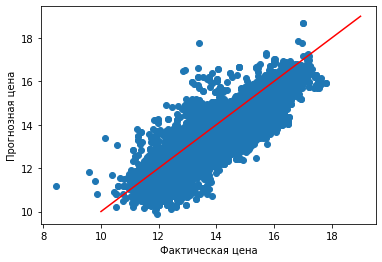

In [158]:
fig.set_size_inches(18.5, 10.5)
plt.scatter(
    [find_prediction_at_instance_for_ols(X, res.params, i) for i in range(X.shape[0])],
    np.log(df.Цена))
plt.plot(list(range(10, 20)),list(range(10, 20)), c = 'red')
plt.xlabel('Фактическая цена')
plt.ylabel('Прогнозная цена')
plt.show()

In [159]:
res.predict(X)

array([15.47635108, 16.11579611, 15.93193008, ..., 12.90104899,
       13.24454527, 12.94910751])

In [163]:
r2_score(y, np.exp(res.predict(X)))

-3544765247839.143

In [164]:
print(f'R^2: {res.rsquared_adj}')

R^2: 0.9989178258226138


In [165]:
cols = df.columns.to_list()
cols.remove('Цена')

In [166]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [167]:
ols = pd.DataFrame()
ols['feature'] = cols
ols['coefs'] = abs(res.params)
ols['p_value'] = res.pvalues
ols.sort_values(by = 'coefs')

,feature,coefs,p_value
9,Пробег,0.000003,0.000000
52,Объем_багажника_min,0.000007,0.093471
13,model,0.000042,0.007671
22,Диаметр_цилиндра_и_ход_поршня,0.000087,0.456949
44,Полная_масса_кг,0.000114,0.000000
51,Объем_багажника_max,0.000137,0.000000
24,Длина,0.000178,0.000000
37,Снаряженная_масса_кг,0.000191,0.000000
12,pokolenie,0.000243,0.000000
19,Объем_двигателя,0.000258,0.000000


In [168]:
data = df
X = data.drop(['Цена'], axis = 1)
y = data.Цена

In [169]:
prediction = pd.DataFrame()
prediction['pred'] = np.exp(res.predict(X))
prediction['fact'] = y
prediction['abs'] = abs(prediction['fact'] - prediction['pred'])

In [170]:
prediction.T

,0,1,2,3,4,5,6,7,8,9,...,36655,36656,36657,36658,36659,36660,36661,36662,36663,36664
pred,5263733.280527,9977030.964446,8301361.371635,10024888.964533,8479058.435543,9316551.918289,4716901.740768,5263733.280527,10233010.141973,4781946.353372,...,682140.463895,550513.568064,332038.133280,380785.204667,461473.569556,484082.955598,621451.172942,400732.336917,564979.809546,420461.211712
fact,12902800.000000,15709500.000000,13890000.000000,13116000.000000,11450000.000000,14599000.000000,11898000.000000,15145200.000000,18545400.000000,11798000.000000,...,475000.000000,320000.000000,350000.000000,330000.000000,345000.000000,300000.000000,330000.000000,654000.000000,500000.000000,400000.000000
abs,7639066.719473,5732469.035554,5588638.628365,3091111.035467,2970941.564457,5282448.081711,7181098.259232,9881466.719473,8312389.858027,7016053.646628,...,207140.463895,230513.568064,17961.866720,50785.204667,116473.569556,184082.955598,291451.172942,253267.663083,64979.809546,20461.211712


In [171]:
def millions(x, pos):
    return '{:,.1f}M'.format(x*1e-7)
fmtr = matplotlib.ticker.FuncFormatter(millions)

OLS score = 0.5388802645484072


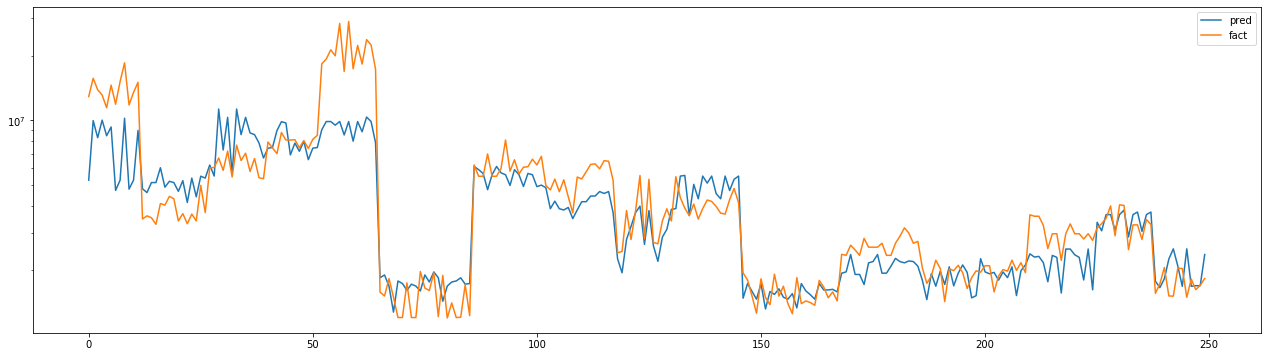

In [172]:
from sklearn.metrics import r2_score

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

plt.plot(range(250), prediction['pred'][:250], label = 'pred')
plt.plot(range(250), prediction['fact'][:250], label = 'fact')
plt.yscale('log')
plt.legend()
print(f'OLS score = {r2_score(y, np.exp(res.predict(X)))}')

## Вывод: модель ужастна, проще бросать монетку на удачу

# Lasso and Ridge

In [173]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

In [174]:
lasso = Lasso(random_state = 1)
lasso.fit(X, np.log(y))

ridge = Ridge(random_state = 1)
ridge.fit(X, np.log(y))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1, solver='auto', tol=0.001)

Lasso score = 0.5168281117187625
Ridge score = 0.5495313200929072


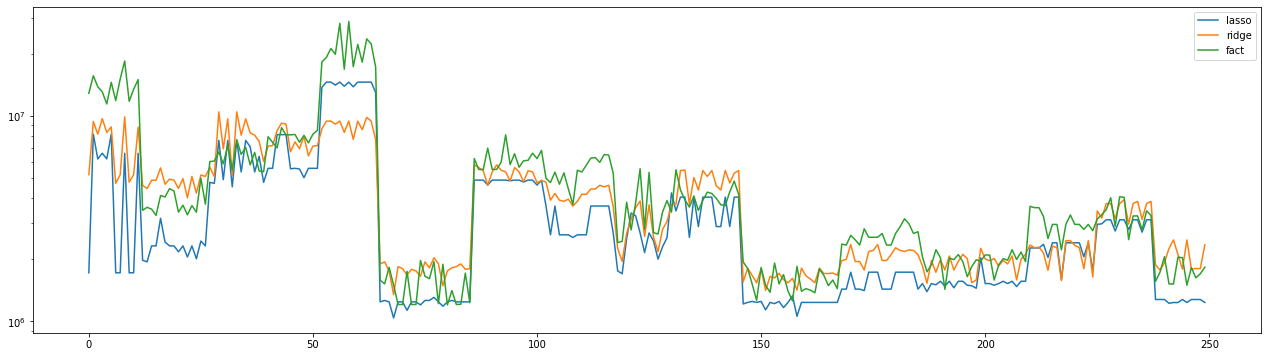

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

plt.plot(range(250), np.exp(lasso.predict(X.iloc[:250, ])), label = 'lasso')
plt.plot(range(250), np.exp(ridge.predict(X.iloc[:250, ])), label = 'ridge')
plt.plot(range(250), y.iloc[:250, ], label = 'fact')
plt.yscale('log')
plt.legend()
print(f'Lasso score = {r2_score(y, np.exp(lasso.predict(X)))}')
print(f'Ridge score = {r2_score(y, np.exp(ridge.predict(X)))}')

## Вывод: Lasso and Ridge не особо помогли решить данную задачу

# Пробуем увеличить результат с помощью подбора scaler и методов машинного обучения

In [176]:
df = pd.read_csv('autoru_v01.csv', index_col = 'Unnamed: 0')
df.head()

,mark,Коробка,Привод,Количество_мест,Количество_дверей,Страна_марки,Тип_двигателя,Объем,Цвет,Пробег,...,Расход,Система_питания_двигателя,Рестайлинг,Cерия_начала_выпуска,Cерия_конца_выпуска,Объем_багажника_max,Объем_багажника_min,Расход_город,Расход_трасса,Расход_среднее
0,Mercedes-Benz,автомат,полный,5.000000,5.000000,Германия,дизель,2.900000,Чёрный,0.000000,...,9.800000,NaN,0.000000,2018.000000,2020.000000,667.000000,1941.000000,11.500000,9.200000,9.800000
1,Mercedes-Benz,автомат,полный,5.000000,5.000000,Германия,дизель,2.900000,Зелёный,0.000000,...,9.600000,NaN,0.000000,2018.000000,2020.000000,667.000000,1941.000000,10.800000,8.900000,9.600000
2,Mercedes-Benz,автомат,полный,5.000000,5.000000,Германия,бензин,4.000000,чёрный,15500.000000,...,12.100000,непосредственный впрыск (прямой),0.000000,2018.000000,2020.000000,667.000000,1941.000000,14.100000,10.800000,12.100000
3,Mercedes-Benz,автомат,полный,5.000000,5.000000,Германия,бензин,4.000000,Чёрный,0.000000,...,12.100000,непосредственный впрыск (прямой),0.000000,2018.000000,2020.000000,667.000000,1941.000000,14.100000,10.800000,12.100000
4,Mercedes-Benz,автомат,полный,5.000000,5.000000,Германия,бензин,4.000000,серый,15297.000000,...,12.100000,непосредственный впрыск (прямой),0.000000,2018.000000,2020.000000,667.000000,1941.000000,14.100000,10.800000,12.100000


In [177]:
df.fillna('error', inplace = True)

In [178]:
def encode_categorial(name_scaler, scaler, data, y = None, return_scaler = False):
    if name_scaler != 'TargetEncoder':
        if not return_scaler:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str)))
        else:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str))), scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data[categorical_cols], y)
        else:
            return scaler.fit_transform(data[categorical_cols], y), scaler
    
def encode_number(name_scaler, scaler, data, return_scaler = False):
    if name_scaler == 'Not scaled':
        if not return_scaler:
            return data
        else:
            return data, scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data)
        else:
            return scaler.fit_transform(data), scaler

In [179]:

scalers_categorial = {'LabelEncoder': LabelEncoder(), 
                     'TargetEncoder': TargetEncoder()}

mls = {
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0), 
        'linear': LinearRegression(), 'RandomForestRegressor':RandomForestRegressor(max_depth=2, random_state=0),
        'LassoCV': LassoCV(), 'Ridge': RidgeCV(), 'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
        }

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler(),
           'RobustScaler': RobustScaler(), 'Normalizer': Normalizer(), 'Not scaled': 0}

mlss = []

X = df.drop(['Цена'], axis = 1)
y = df['Цена']

numbers_cols, categorical_cols = get_cols(X)

for idd, (name_ml, ml) in enumerate(mls.items()):
    data = pd.DataFrame()
    for ide, (name_scaler_categorial, scaler_categorial) in enumerate(scalers_categorial.items()):
        data[categorical_cols] = encode_categorial(name_scaler_categorial, scaler_categorial, X[categorical_cols], y)
        
        for name_scaler, scaler in scalers.items():
            for name in numbers_cols:
                data[name] = 0
            
            data[numbers_cols] = encode_number(name_scaler, scaler, X[numbers_cols])

            
            X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42, shuffle = True)
        
            model = ml.fit(X_train, y_train)
        
            #mlss[name+ ' '+ str(ide)] = {'categorial encoding': i,'number encoding': name_scaler,
            #                            'score': round(model.score(X_test, y_test),3)}
            mlss.append([name_ml, name_scaler_categorial, name_scaler, round(model.score(X_test, y_test),3)])

In [180]:
sorted(mlss, key = lambda x: x[3], reverse = True)

[['ExtraTreesRegressor', 'TargetEncoder', 'Normalizer', 0.963],
 ['ExtraTreesRegressor', 'LabelEncoder', 'StandardScaler', 0.942],
 ['ExtraTreesRegressor', 'LabelEncoder', 'MinMaxScaler', 0.942],
 ['ExtraTreesRegressor', 'LabelEncoder', 'RobustScaler', 0.942],
 ['ExtraTreesRegressor', 'LabelEncoder', 'Not scaled', 0.942],
 ['ExtraTreesRegressor', 'TargetEncoder', 'StandardScaler', 0.939],
 ['ExtraTreesRegressor', 'TargetEncoder', 'MinMaxScaler', 0.939],
 ['ExtraTreesRegressor', 'TargetEncoder', 'RobustScaler', 0.939],
 ['ExtraTreesRegressor', 'TargetEncoder', 'Not scaled', 0.939],
 ['ExtraTreesRegressor', 'LabelEncoder', 'Normalizer', 0.938],
 ['GradientBoostingRegressor', 'TargetEncoder', 'Normalizer', 0.921],
 ['GradientBoostingRegressor', 'LabelEncoder', 'StandardScaler', 0.898],
 ['GradientBoostingRegressor', 'LabelEncoder', 'MinMaxScaler', 0.898],
 ['GradientBoostingRegressor', 'LabelEncoder', 'RobustScaler', 0.898],
 ['GradientBoostingRegressor', 'LabelEncoder', 'Not scaled', 0.8

## Как мы можем заметить нам лучше всего использовать ExtraTreesRegressor c target ##кодированием категориальных и 'Normalizer' числовых переменных

In [181]:
# реализуем это

data = df.copy()

numbers_cols, categorical_cols = get_cols(df.drop(['Цена'], axis = 1))

data[categorical_cols], scaler_categorial = encode_categorial('TargetEncoder', TargetEncoder(), data[categorical_cols], y, return_scaler = True)
data[numbers_cols], scaler_number = encode_number('Normalizer', Normalizer(), data[numbers_cols], return_scaler = True)

X = data.drop(['Цена'], axis = 1)
y = np.log(data['Цена'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)

model = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
model_boost = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)

ExtraTrees score = 0.9799076983719606
GradientBoostingRegressor score = 0.9224942173975024


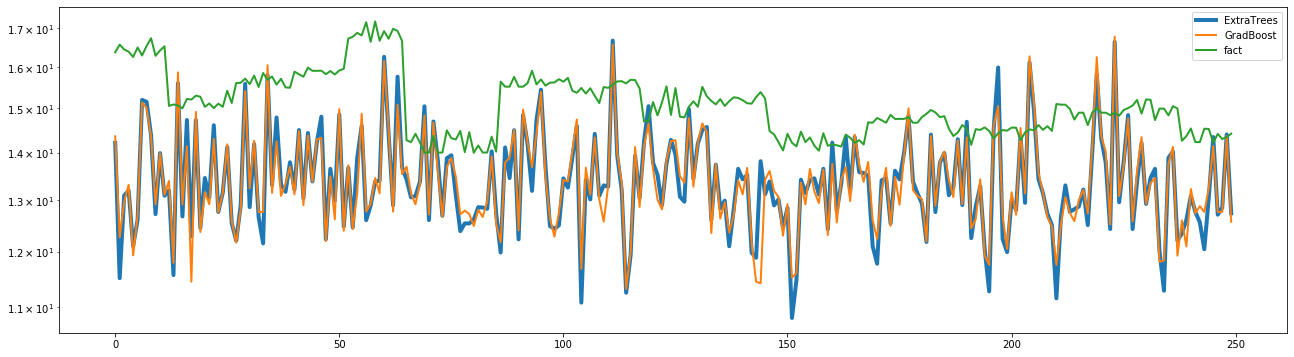

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

x = X.sample(250)
plt.plot(range(250), model.predict(x), label = 'ExtraTrees', linewidth=4.0)
plt.plot(range(250), model_boost.predict(x), label = 'GradBoost', linewidth=2.0)
plt.plot(range(250), y.iloc[:250, ], label = 'fact', linewidth=2.0)

plt.yscale('log')
plt.legend()
print(f'ExtraTrees score = {r2_score(y, model.predict(X))}')
print(f'GradientBoostingRegressor score = {r2_score(y, model_boost.predict(X))}')

# вывод: мы смогли достичь высокого результата с помощью ExtraTrees и градиентного бустинга

In [183]:
df[categorical_cols]

,mark,Коробка,Привод,Страна_марки,Тип_двигателя,Цвет,car_type,pokolenie,model,Топливо,...,Расположение_цилиндров,Передние_тормоза,Тип_передней_подвески,Класс_автомобиля,Марка_топлива,Тип_задней_подвески,Задние_тормоза,Расположение_двигателя,Размер_колёс,Система_питания_двигателя
0,Mercedes-Benz,автомат,полный,Германия,дизель,Чёрный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,ДТ,...,рядное,дисковые вентилируемые,"независимая, пружинная",J,ДТ,"зависимая, пружинная",дисковые,"переднее, продольное",265/60/R18,error
1,Mercedes-Benz,автомат,полный,Германия,дизель,Зелёный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,ДТ,...,рядное,дисковые вентилируемые,"независимая, пружинная",J,ДТ,"зависимая, пружинная",дисковые,"переднее, продольное",error,error
2,Mercedes-Benz,автомат,полный,Германия,бензин,чёрный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,АИ-95,...,V-образное,дисковые вентилируемые,"независимая, пружинная",J,АИ-95,"зависимая, пружинная",дисковые вентилируемые,"переднее, продольное",265/60/R18,непосредственный впрыск (прямой)
3,Mercedes-Benz,автомат,полный,Германия,бензин,Чёрный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,АИ-95,...,V-образное,дисковые вентилируемые,"независимая, пружинная",J,АИ-95,"зависимая, пружинная",дисковые вентилируемые,"переднее, продольное",265/60/R18,непосредственный впрыск (прямой)
4,Mercedes-Benz,автомат,полный,Германия,бензин,серый,Внедорожник,III (W463) 2018 – н.в.,G-Класс,АИ-95,...,V-образное,дисковые вентилируемые,"независимая, пружинная",J,АИ-95,"зависимая, пружинная",дисковые вентилируемые,"переднее, продольное",265/60/R18,непосредственный впрыск (прямой)
5,Mercedes-Benz,автомат,полный,Германия,дизель,Чёрный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,ДТ,...,рядное,дисковые вентилируемые,"независимая, пружинная",J,ДТ,"зависимая, пружинная",дисковые,"переднее, продольное",error,error
6,Mercedes-Benz,автомат,полный,Германия,дизель,чёрный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,ДТ,...,рядное,дисковые вентилируемые,"независимая, пружинная",J,ДТ,"зависимая, пружинная",дисковые,"переднее, продольное",265/60/R18,error
7,Mercedes-Benz,автомат,полный,Германия,дизель,Чёрный,Внедорожник,III (W463) 2018 – н.в.,G-Класс,ДТ,...,рядное,дисковые вентилируемые,"независимая, пружинная",J,ДТ,"зависимая, пружинная",дисковые,"переднее, продольное",265/60/R18,error
8,Mercedes-Benz,автомат,полный,Германия,бензин,Серый,Внедорожник,III (W463) 2018 – н.в.,G-Класс,АИ-95,...,V-образное,дисковые вентилируемые,"независимая, пружинная",J,АИ-95,"зависимая, пружинная",дисковые вентилируемые,"переднее, продольное",265/60/R18,непосредственный впрыск (прямой)
9,Mercedes-Benz,автомат,полный,Германия,дизель,синий,Внедорожник,III (W463) 2018 – н.в.,G-Класс,ДТ,...,рядное,дисковые вентилируемые,"независимая, пружинная",J,ДТ,"зависимая, пружинная",дисковые,"переднее, продольное",265/60/R18,error


In [184]:
# построим упрощенную модель ExtreTrees с необходимыми параметрами
da = df[['mark', 'model', 'Цвет', 'год_выпуска', 'Пробег', 'Максимальная_скорость', 'Цена']]


numbers_cols, categorical_cols = get_cols(da.drop(['Цена'], axis = 1))


da[categorical_cols], scale_categorial = encode_categorial('TargetEncoder', TargetEncoder(), da[categorical_cols], np.log(da['Цена']), return_scaler = True)
da[numbers_cols], scale_number = encode_number('Normalizer', Normalizer(), da[numbers_cols], return_scaler = True)

X = da.drop(['Цена'], axis = 1)
y = np.log(da['Цена'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)

model = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

In [185]:
from sklearn.pipeline import Pipeline

model_te = Pipeline([
    ('encoder', scale_categorial),
    ('scaler', scale_number),
    ('regressor', ExtraTreesRegressor(n_estimators=100, random_state=0))
])

X_train, X_test, y_train, y_test = train_test_split(df[['mark', 'model', 'Цвет', 'год_выпуска', 'Пробег', 'Максимальная_скорость']],
                                                    df['Цена'], test_size=0.33, random_state=42, shuffle = True)

model_te.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('encoder',
                 TargetEncoder(cols=['mark', 'model', 'Цвет'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('scaler', Normalizer(copy=True, norm='l2')),
                ('regressor',
                 ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                          

In [186]:
r2_score(y_test, model_te.predict(X_test))

0.9228342591154667

In [187]:
from IPython.display import display
from ipywidgets import Dropdown
from ipywidgets import FloatSlider
from ipywidgets import RadioButtons
from ipywidgets import Button, Layout


def on_button_clicked(b):
    t = pd.DataFrame(data = [mark.value, model_car.value, color.value, years.value, race.value, max_speed.value]).T
    t.columns = ['mark', 'model', 'Цвет', 'год_выпуска', 'Пробег', 'Максимальная_скорость']
    print('Цена вашего авто = {:.0f}руб.'.format(model_te.predict(t)[0]))
    

mark = Dropdown(
    options=sorted([i for i in df['mark'].unique()]),
    #value=2, # Выбор по умолчанию
    description='Марка:' 
)

model_car = Dropdown(
    options=sorted([i for i in df['model'].unique()]),
    #value=2, # Выбор по умолчанию
    description='Модель:' 
)

color = Dropdown(
    options=sorted([i for i in df['Цвет'].unique()]),
    #value=2, # Выбор по умолчанию
    description='Цвет:' 
)

years = FloatSlider(value=2016, min=df['год_выпуска'].unique().min(),
                    max=df['год_выпуска'].unique().max(), step=1,
                  description='Год:',
                  continuous_update=False, 
                  orientation='horizontal')

race = FloatSlider(value=0, min=df['Пробег'].unique().min(),
                    max=df['Пробег'].unique().max(), step=1,
                  description='Пробег:',
                  continuous_update=False, 
                  orientation='horizontal')

max_speed = FloatSlider(value=80, min=df['Максимальная_скорость'].unique().min(),
                    max=df['Максимальная_скорость'].unique().max(), step=1,
                  description='Скорость:',
                  continuous_update=False, 
                  orientation='horizontal')

ans = Button(description='Рассчитать стоимость', button_style='success',
           layout=Layout(width='50%', height='80px'))
ans.on_click(on_button_clicked)

display(mark)
display(model_car)
display(color)
display(years)
display(race)
display(max_speed)
display(ans)


Dropdown(description='Марка:', options=('AC ', 'AMC ', 'Acura ', 'Alfa Romeo ', 'Aston Martin ', 'Audi ', 'BMW…

Dropdown(description='Модель:', options=('1 серии ', '100 ', '1007 ', '107 ', '1111 Ока ', '12 ЗИМ ', '13 «Чай…

Dropdown(description='Цвет:', options=('Бежевый', 'Белый', 'Голубой', 'Жёлтый', 'Зелёный', 'Золотистый', 'Кори…

FloatSlider(value=2016.0, continuous_update=False, description='Год:', max=2020.0, min=1927.0, step=1.0)

FloatSlider(value=0.0, continuous_update=False, description='Пробег:', max=1000000.0, step=1.0)

FloatSlider(value=80.0, continuous_update=False, description='Скорость:', max=341.0, min=75.0, step=1.0)

Button(button_style='success', description='Рассчитать стоимость', layout=Layout(height='80px', width='50%'), …

# Кластерный анализ

In [188]:
df = pd.read_csv('autoru_v01.csv', index_col = 'Unnamed: 0')[['Количество_мест', 'Объем', 'Пробег', 'Цена', 'год_выпуска',
                               'Максимальная_мощность', 'Количество_цилиндров', 'Разгон_до_100_с',
                                'Расход', 'Расход_среднее']]

#df[['Цена']] = np.log(df[['Цена']])
df.head()

,Количество_мест,Объем,Пробег,Цена,год_выпуска,Максимальная_мощность,Количество_цилиндров,Разгон_до_100_с,Расход,Расход_среднее
0,5.000000,2.900000,0.000000,12902800.000000,2020.000000,249.000000,6.000000,7.400000,9.800000,9.800000
1,5.000000,2.900000,0.000000,15709500.000000,2020.000000,330.000000,6.000000,6.400000,9.600000,9.600000
2,5.000000,4.000000,15500.000000,13890000.000000,2019.000000,422.000000,8.000000,5.900000,12.100000,12.100000
3,5.000000,4.000000,0.000000,13116000.000000,2020.000000,422.000000,8.000000,5.900000,12.100000,12.100000
4,5.000000,4.000000,15297.000000,11450000.000000,2019.000000,422.000000,8.000000,5.900000,12.100000,12.100000


In [189]:
link = linkage(df, 'ward', 'euclidean')

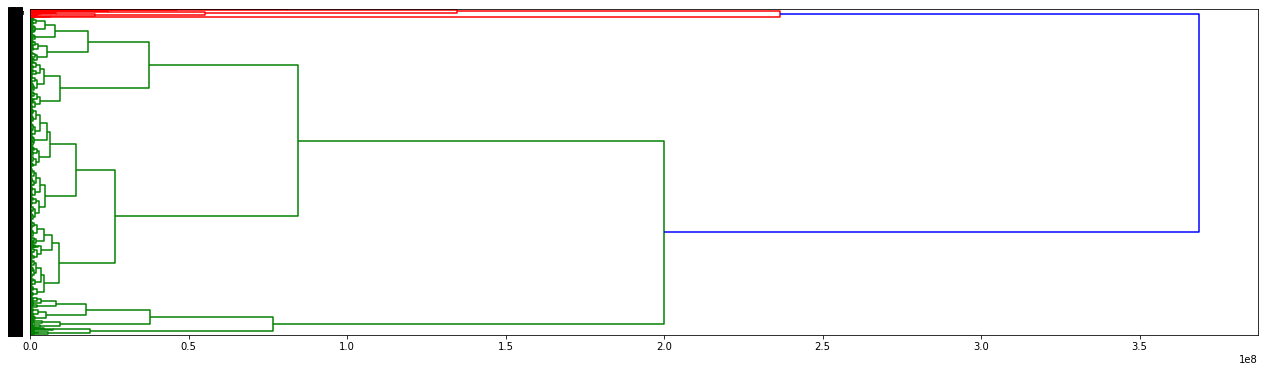

In [190]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))
dn = dendrogram(link, orientation = "right")

In [191]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')
df.groupby('cluster').median().T.round(2)

cluster,1,2,3,4
Количество_мест,5.000000,5.000000,4.000000,5.000000
Объем,3.000000,2.000000,6.000000,4.000000
Пробег,30000.000000,140670.000000,1724.000000,8.500000
Цена,3197000.000000,579000.000000,130000000.000000,10000000.000000
год_выпуска,2018.000000,2009.000000,2009.000000,2020.000000
Максимальная_мощность,249.000000,141.000000,612.000000,456.000000
Количество_цилиндров,6.000000,4.000000,12.000000,8.000000
Разгон_до_100_с,7.400000,10.700000,5.200000,4.900000
Расход,7.500000,7.300000,16.400000,9.900000
Расход_среднее,7.300000,7.200000,16.400000,9.300000


In [192]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


numbers_cols, categorical_cols = get_cols(df.drop(['Цена'], axis = 1))
df[categorical_cols] = encode_categorial('TargetEncoder', TargetEncoder(), df[categorical_cols], df['Цена'])
df[numbers_cols], scale_number = encode_number('Normalizer', Normalizer(), df[numbers_cols], return_scaler = True)

df.head()

,Количество_мест,Объем,Пробег,Цена,год_выпуска,Максимальная_мощность,Количество_цилиндров,Разгон_до_100_с,Расход,Расход_среднее,cluster
0,0.002457,0.001425,0.000000,12902800.000000,0.992448,0.122336,0.002948,0.003636,0.004815,0.004815,0.001965
1,0.002443,0.001417,0.000000,15709500.000000,0.986880,0.161223,0.002931,0.003127,0.004690,0.004690,0.001954
2,0.000320,0.000256,0.991261,13890000.000000,0.129120,0.026988,0.000512,0.000377,0.000774,0.000774,0.000256
3,0.002423,0.001938,0.000000,13116000.000000,0.978816,0.204485,0.003876,0.002859,0.005863,0.005863,0.001938
4,0.000324,0.000259,0.991030,11450000.000000,0.130803,0.027340,0.000518,0.000382,0.000784,0.000784,0.000259


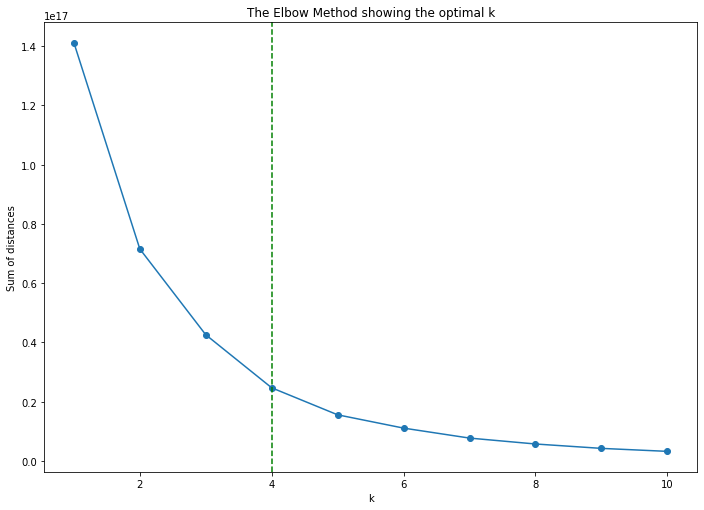

In [193]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns


K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(df.iloc[:, :]) for k in K]
dist = [model.inertia_ for model in models]

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.axvline(4, c='g', linestyle='dashed')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [194]:
df.head()

,Количество_мест,Объем,Пробег,Цена,год_выпуска,Максимальная_мощность,Количество_цилиндров,Разгон_до_100_с,Расход,Расход_среднее,cluster
0,0.002457,0.001425,0.000000,12902800.000000,0.992448,0.122336,0.002948,0.003636,0.004815,0.004815,0.001965
1,0.002443,0.001417,0.000000,15709500.000000,0.986880,0.161223,0.002931,0.003127,0.004690,0.004690,0.001954
2,0.000320,0.000256,0.991261,13890000.000000,0.129120,0.026988,0.000512,0.000377,0.000774,0.000774,0.000256
3,0.002423,0.001938,0.000000,13116000.000000,0.978816,0.204485,0.003876,0.002859,0.005863,0.005863,0.001938
4,0.000324,0.000259,0.991030,11450000.000000,0.130803,0.027340,0.000518,0.000382,0.000784,0.000784,0.000259


In [195]:
sc = Normalizer()
df['Цена'] = sc.fit_transform([df['Цена']])[0]

In [196]:
df['cluster'] = fcluster(link, 5, criterion='maxclust')

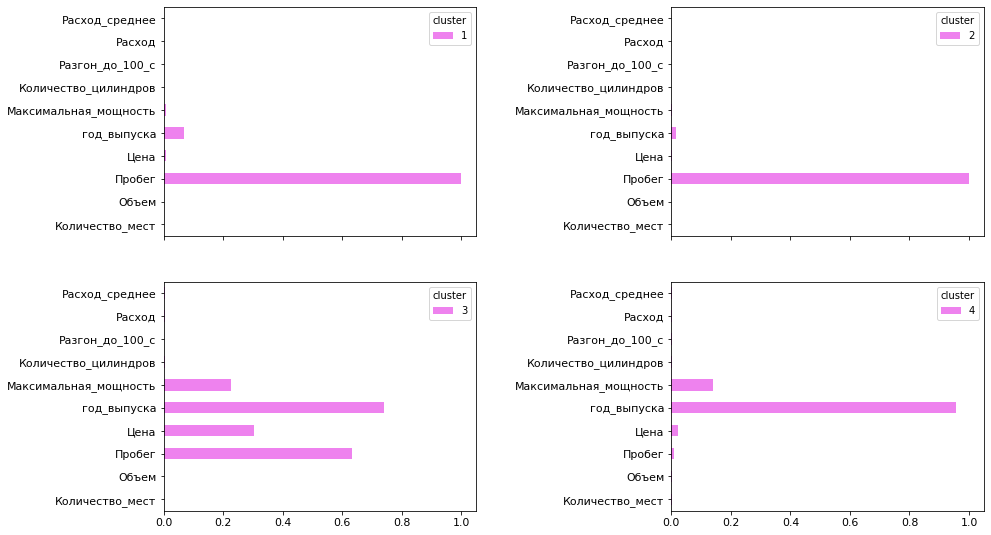

In [197]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(14.7, 9.27)
plt.subplots_adjust( wspace=0.625)
k = 0
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange']
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        k += 1
        df[df.cluster == k].groupby('cluster').median().T.plot.barh(ax = ax, color = c[1])
        ax.tick_params(labelsize = 11)

In [198]:
df.groupby('cluster').mean().T.round(2)

cluster,1,2,3,4,5
Количество_мест,0.000000,0.000000,0.000000,0.000000,0.000000
Объем,0.000000,0.000000,0.000000,0.000000,0.000000
Пробег,0.720000,0.960000,0.630000,0.390000,0.270000
Цена,0.010000,0.000000,0.300000,0.020000,0.050000
год_выпуска,0.330000,0.060000,0.740000,0.660000,0.760000
Максимальная_мощность,0.040000,0.000000,0.230000,0.140000,0.190000
Количество_цилиндров,0.000000,0.000000,0.000000,0.000000,0.000000
Разгон_до_100_с,0.000000,0.000000,0.000000,0.000000,0.000000
Расход,0.000000,0.000000,0.010000,0.000000,0.000000
Расход_среднее,0.000000,0.000000,0.010000,0.000000,0.000000


# 